**<center><font size=5>Orbital Abscess Detection with VGG-16 Model</font></center>**
***
**Authors**: Ryan Summers and Bill Steel

**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a>
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. What is an Orbital Abscess?</a>
- <a href='#env'>2. Import Libraries and Confirm GPU</a>
- <a href='#import'>3. Data Import and Preprocessing</a>
- <a href='#cnn'>4. CNN Model</a>
    - <a href='#aug'>4.1. Data Augmentation</a>
    - <a href='#build'>4.2. Model Building</a>
    - <a href='#perf'>4.3. Model Performance</a>
- <a href='#concl'>5. Conclusions</a>
- <a href='#cite'>6. References</a>

# <a id='intro'>1. Project Overview and Objectives</a>


Orbital cellulitis (OC) is the most common cause of ophthalmic admissions among children in the United States (US). OC is a very rare, infectious, non-communicable disease that does not require reporting to the Centers for Disease Control and Prevention (CDC). As such, only a few studies have been published on OC in children and its complications. One such complication is the presence of an orbital abscess, which occurs posterior to the orbital septum (behind the eyelids in the orbit). It's important to note that OC can occur with or without abscesses.

<div style="text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <img src="orbitalabscess.png" width="300" style="padding: 20px;"/>
</div>

The presence of an orbital abscess may require surgical intervention based on the location and size of the abscess. Surgical intervention is not usually warranted if the abscess is located in the medial section of the orbit (closest to the nose), which is generally just monitored. However, abscesses in the superior (roof) and inferior (floor) locations generally require surgical intervention.

<div style="text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <img src="orbitallocations.png" width="300" style="padding: 20px;"/>
</div>

When dealing with the pediatric population, being able to accurately identify these characteristics (location and size of the abscess) is crucial because ideally, we do not want to subject children to surgical interventions unnecessarily. The main objective of this project is to build a CNN (Convolutional Neural Network) model that would classify whether a pediatric patient has an orbital abscess based on CT (Computed Tomography) imaging. Secondary objectives are to be able to accurately identify the orbital location of the abscess and its size. By being able to identify the location and size, proper treatment plans can be established, and it can help with studies that aim to determine the need for surgery based on size.


 The [VGG-16] model architecture and weights were used to train the model for this binary problem. Confusion matrix statistics will be used to quantify the performance of the model.


Final results look as follows:


| Set | Accuracy |
|:-:|:--------:|
| Validation Set* |  ~89.67%   |
| Test Set* |  ~82.10%   |

<br>

| Metrics | Accuracy |
|:-:|:--------:|
| Precision* |  ~82.28%   |
| Recall* |  ~82.10%   |
| F1-Score* |  ~82.04%   |



\* *Clarrification on above terms:*
* *`validation set` - the set used during model training to adjust the hyperparameters.*
* *`test set` - the small set that is not observed by the model during the training process. It is used to evaluate the final model performance.*

<br> 

* *`Precision` - the ratio of correctly predicted positive cases of orbital cellulitis to the total predicted cases. It answers the question: "Of all the instances that were predicted as positive, how many were actually positive?" - crucial when the cost of False Positives (FP) are high.* $$\text{Precision} = \frac{ \text{True Positives (TP)} }{ \text{True Positives (TP)} + \text{False Positives (FP)} }$$
* *`Recall (Sensitivity)` - the ratio of correctly predicted positive orbital cellulitis to all positive cases of orbital cellulitis. It answers the question: "Of all the actual cases of orbital cellulitis, how many were correctly predicted?" - crucial when the cost of False Negative (FN) is high.* $$\text{Recall} = \frac{ \text{True Positives (TP)} }{ \text{True Positives (TP)} + \text{False Negatives (FN)} }$$
* *`F1-Score` - is a harmonic mean of Precision and Recall and gives a better measure of the
incorrectly classified cases than the accuracy metrics. It balances the two metrics, providing a single metric that is useful when you need to find a trade-off between precision and recall. Most useful when working with imbalances datasets.* $$\text{F1-Score} = \text{2 x }\frac{ \text{Precision x Recall} }{ \text{Precision + Recall} }$$




## <a id='dataset'>1.1. Data Set Description</a>

Imaging was provided by the University of Colorado Anschutz Ophthalmology Department. It consists of 165 coronal cuts of orbital CT scans obtained from children admitted to the hospital between January 1, 2018 and December 21, 2022, with the diagnosis of OC. Preprocessing was done to crop the areas around both the infected eye and healthy eye, which acts as a natural control for comparison between patients. The images were seperated into two classes:

* `Healthy` - no abscess, encoded as `0`
* `Infected` - abscess present, encoded as `1`


## <a id='tumor'>1.2. What is an Orbital Abscess?</a>

> Orbital abscesses are collections of pus within the orbital soft tissue. When an area in the body becomes infected, the body's immune system sends white blood cells to fight the infection. These cells collect and combine with the damaged tissue and germs, creating liquid called pus. Infections of the orbit are uncommon, but they are potentially devastating infections that can quickly result in blindness, meningitis, or death. The emergency physician must make a rapid and accurate diagnosis and then quickly initiate therapy because visual loss is associated directly with the length of time to definitive treatment.

Source: [Medscape](https://emedicine.medscape.com/article/784888-overview?form=fpf)
Source: [Cleveland Clinic](https://my.clevelandclinic.org/health/diseases/22876-abscess)

# <a id='env'>2. Import Libraries and Confirm GPU</a>

In [ ]:
# FYI system info
import sys
print(sys.version)


In [1]:
# Load Libraries
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import re
import importlib
importlib.invalidate_caches()
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
from tqdm import tqdm
import cv2
import itertools
import imutils

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.regularizers import l2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.losses import BinaryCrossentropy
from keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, F1Score


import nibabel as nib
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull
#from skimage import measure

import glob
import csv

In [2]:
# Check if TensorFlow is using GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Force TensorFlow to use GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available: 1
GPU is available


In [24]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print(current_directory)

/home/kalokai/miniconda3/envs/tf_gpu/ist691


# <a id='import'>3. Data Import and Preprocessing</a>

In [3]:
# Image Load function

def load_images(directory, image_size):
    images = []  # Initializing list to store loaded images
    # Getting all PNG files
    filenames = [f for f in sorted(os.listdir(directory)) if f.endswith('.png')]

    for filename in filenames:
        # Constructing full file path
        file_path = os.path.join(directory, filename)
        # Opening the image file
        with Image.open(file_path) as img:
            # Converting image to grayscale ('L' mode) and resize if not already
            img = img.convert('L') if img.mode != 'L' else img
            # Using the correct resampling filter for resizing
            img = img.resize(image_size, Image.Resampling.LANCZOS)
            # Converting image data to numpy array and normalize the pixel values
            img_array = np.array(img) / 255.0
            # Appending the image array to the list
            images.append(img_array)

    # Converting list of arrays into a numpy array (batch_size, height, width, channels)
    return np.expand_dims(np.array(images), axis=-1)


In [158]:
# Loading the images

image_size = (224, 224)  # Resize images to 224x224
images_data = load_images("Abscess Stills", image_size)
print(images_data.shape)

(165, 224, 224, 1)


In [159]:
#  Function to display the images

def display_images(images, number_of_images=5):
    # Setting up the figure size and number of subplots
    fig, axs = plt.subplots(1, number_of_images, figsize=(15, 5))

    # Looping
    for i in range(number_of_images):
        # Selecting the subplot and turn off the axis
        ax = axs[i]
        ax.axis('off')

        # Displaying image in grayscale
        ax.imshow(images[i, :, :, 0], cmap='gray')

        # Giving a title for each image
        ax.set_title(f'Image {i+1}')

    # Showing the plot
    plt.show()

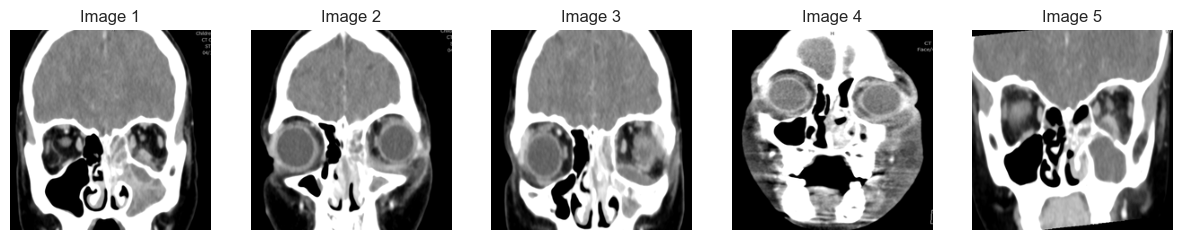

In [160]:
# Calling my function to see the images
display_images(images_data, number_of_images=5)

In [ ]:
import dlib
print("Dlib version:", dlib.__version__)


In [ ]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [ ]:
# Initialize the detector and predictor (make sure the predictor has already been loaded)
detector = dlib.get_frontal_face_detector()

def detect_eyes(image_path):
    # Load the image
    image = Image.open(image_path).convert('L')
    image_np = np.array(image, dtype='uint8')

    # Detect faces in the image
    faces = detector(image_np, 1)
    eye_regions = []

    for face in faces:
        landmarks = predictor(image_np, face)

        # Trying to extract the eye regions using the landmark indices
        # Indices for the left eye are 36 to 41 and for the right eye are 42 to 47
        left_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
        right_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
        eye_regions.append((left_eye, right_eye))

    return eye_regions

In [ ]:
# Testing - BE SURE TO CHANGE DIRECTORY TO YOUR IMAGES!!
eye_regions = detect_eyes('Abscess Stills/Superior left 21514.png') # Superior left 21514 ; Right medial 15782

In [6]:
# Testing
def plot_eyes(image_path, eye_regions):
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray')
    ax = plt.gca()

    for eyes in eye_regions:
        left_eye, right_eye = eyes
        # Plot each eye region
        for (x, y) in left_eye:
            ax.scatter(x, y, color='red')
        for (x, y) in right_eye:
            ax.scatter(x, y, color='blue')

    plt.show()

In [ ]:
plot_eyes('Abscess Stills/Superior left 21514.png', eye_regions)

In [8]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1] - ADD_PIXELS:extBot[1] + ADD_PIXELS,
                  extLeft[0] - ADD_PIXELS:extRight[0] + ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
img = cv2.imread('Abscess Stills/Superior left 21514.png')
img = cv2.resize(
            img,
            dsize=image_size,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])

plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])

plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])

plt.title('Step 4. Crop the image')
plt.show()

In [9]:
def is_eye_region(x, y, r, image_shape):
    """
    Checks if the detected circle is in the typical eye region of the CT scan.
    Adjust the conditions based on the specific characteristics of the eye regions in your dataset.
    """
    height, width = image_shape[:2]
    min_x, max_x = int(0.2 * width), int(0.8 * width)  # Eyes should be within the central horizontal range
    min_y, max_y = int(0.3 * height), int(0.6 * height)  # Eyes should be within the upper half of the face
    min_radius, max_radius = 10, 40  # Eyes should have a reasonable radius size

    return (min_x <= x <= max_x) and (min_y <= y <= max_y) and (min_radius <= r <= max_radius)


In [10]:
def crop_eyes(img, add_pixels_value=20):  # Default to adding 20 pixels around the detected region
    """
    Detects eyes using Hough Circle Transform and crops them out of the image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    # Detect circles in the image
    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=50,
        param1=50,
        param2=30,
        minRadius=20,
        maxRadius=40
    )

    # Ensure at least some circles were found
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        set_new = []

        for (x, y, r) in circles:
            if is_eye_region(x, y, r, img.shape):
                # Define the bounding box for each eye
                x1, y1, x2, y2 = x-r-add_pixels_value, y-r-add_pixels_value, x+r+add_pixels_value, y+r+add_pixels_value

                # Ensure the bounding box is within the image dimensions
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(img.shape[1], x2)
                y2 = min(img.shape[0], y2)

                # Crop the image
                new_img = img[y1:y2, x1:x2].copy()
                set_new.append(new_img)

                # Draw the circle and rectangle on the original image (for visualization)
                cv2.circle(img, (x, y), r, (0, 255, 0), 4)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 128, 255), 2)

        return set_new, img
    else:
        print("No eyes detected.")
        return [], img

In [11]:
# Load and process the image **TEST*** REMEMBER TO CHANGE DIRECTORY!!
img = cv2.imread('Abscess Stills/Superior left 21514.png')
image_size = (256, 256)
img = cv2.resize(img, image_size, interpolation=cv2.INTER_CUBIC)

cropped_eyes, img_with_circles = crop_eyes(img, add_pixels_value=20)  # Increase the value to add_pixels_value for a larger crop

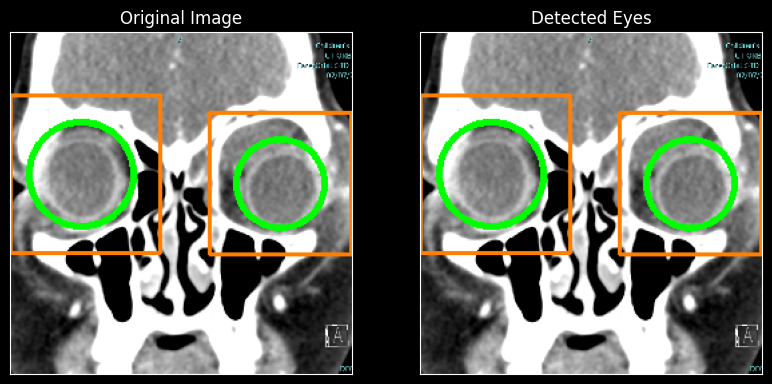

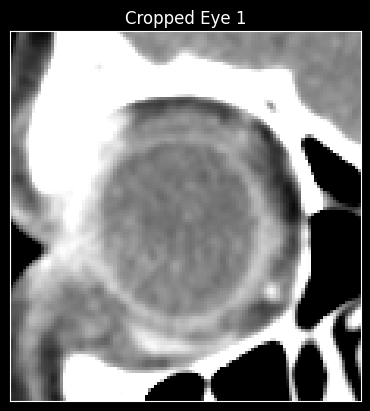

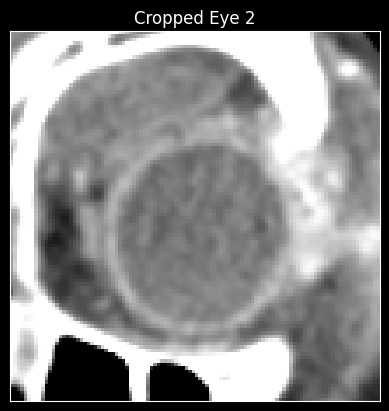

In [12]:
# Display the results
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

if cropped_eyes:
    plt.subplot(132)
    plt.imshow(cv2.cvtColor(img_with_circles, cv2.COLOR_BGR2RGB))
    plt.title('Detected Eyes')
    plt.xticks([])
    plt.yticks([])

    for i, eye in enumerate(cropped_eyes):
        plt.figure()
        plt.imshow(cv2.cvtColor(eye, cv2.COLOR_BGR2RGB))
        plt.title(f'Cropped Eye {i+1}')
        plt.xticks([])
        plt.yticks([])

else:
    plt.subplot(132)
    plt.imshow(cv2.cvtColor(img_with_circles, cv2.COLOR_BGR2RGB))
    plt.title('No Eyes Detected')
    plt.xticks([])
    plt.yticks([])

plt.show()


In [ ]:
# Process the entire directory of images using crop_eyes function
def process_image_directory(input_dir, output_dir, image_size=(256, 256), add_pixels_value=20):
    """
    Process all images in the input directory, detecting and cropping eyes,
    and save the results to the output directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(input_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size, interpolation=cv2.INTER_CUBIC)

            cropped_eyes, img_with_circles = crop_eyes(img, add_pixels_value=add_pixels_value)

            # Save the image with detected circles for visualization
            output_path = os.path.join(output_dir, f"detected_{filename}")
            cv2.imwrite(output_path, img_with_circles)

            # Save each cropped eye image
            for i, eye in enumerate(cropped_eyes):
                eye_output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_eye_{i+1}.png")
                cv2.imwrite(eye_output_path, eye)

    print(f"Processing complete. Check the output directory: {output_dir}")

# CHANGE TO DIRECTORY NAMES OF YOUR CHOOSING!!
input_directory = 'Abscess Stills'
output_directory = 'Cropped'
process_image_directory(input_directory, output_directory)

In [ ]:
'''
Replaces the names from the Healthy folder to the opposite of what file name says.
The OG file names contained the name of the eye and orbital location of the infection.
When processing the images with crop_eyes, the images contained the original file name plus
an iteration number. Therefore, the healthy eye images needed to be changed to the opposing eye
or our "natural control" in this case.
'''


# CHANGE TO YOUR CORRECT DIRECTORY PATH
folder_path = 'Healthy'

# Function to rename files
def rename_files(folder_path):
    # List all files in the directory
    for filename in os.listdir(folder_path):
        # Check if the file is a .png file
        if filename.endswith('.png'):
            print(f'Original filename: {filename}')

            # Replace "left" with "right" and vice versa
            if 'left' in filename.lower():
                new_name = re.sub(r'left', 'temp_placeholder', filename, flags=re.IGNORECASE)
                new_name = re.sub(r'right', 'left', new_name, flags=re.IGNORECASE)
                new_name = re.sub(r'temp_placeholder', 'right', new_name, flags=re.IGNORECASE)
            elif 'right' in filename.lower():
                new_name = re.sub(r'right', 'temp_placeholder', filename, flags=re.IGNORECASE)
                new_name = re.sub(r'left', 'right', new_name, flags=re.IGNORECASE)
                new_name = re.sub(r'temp_placeholder', 'left', new_name, flags=re.IGNORECASE)
            else:
                new_name = filename

            print(f'After swapping left/right: {new_name}')

            # Remove any text after "left" or "right" before the numbers
            new_name = re.sub(r'((left|right)).*?(\d+)', r'\1 \3', new_name, flags=re.IGNORECASE)
            print(f'Final new name: {new_name}')

            # Construct the full old and new file paths
            old_file = os.path.join(folder_path, filename)
            new_file = os.path.join(folder_path, new_name)

            # Rename the file
            os.rename(old_file, new_file)
            print(f'Renamed: {filename} to {new_name}\n')

# Call the function
rename_files(folder_path)


In [3]:
# Function to split folders into train, test, and validation
def create_split_folders(base_dir, categories, split_ratios):
    # Define the splits
    splits = ['train', 'test', 'validation']

    # Create base directories for splits
    for split in splits:
        split_dir = os.path.join(base_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        for category in categories:
            category_split_dir = os.path.join(split_dir, category)
            os.makedirs(category_split_dir, exist_ok=True)


In [4]:
# Function to split the data in to train, test, and validation
def split_dataset(base_dir, categories, split_ratios):
    # Define the splits
    splits = ['train', 'test', 'validation']

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        images = [f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))]

        # Shuffle images randomly
        random.shuffle(images)

        # Calculate split indices
        total_images = len(images)
        train_end = int(split_ratios['train'] * total_images)
        validation_end = train_end + int(split_ratios['validation'] * total_images)

        # Split the images
        train_images = images[:train_end]
        validation_images = images[train_end:validation_end]
        test_images = images[validation_end:]

        # Move images to corresponding split folders
        for image in train_images:
            src = os.path.join(category_dir, image)
            dst = os.path.join(base_dir, 'train', category, image)
            shutil.copy2(src, dst)

        for image in validation_images:
            src = os.path.join(category_dir, image)
            dst = os.path.join(base_dir, 'validation', category, image)
            shutil.copy2(src, dst)

        for image in test_images:
            src = os.path.join(category_dir, image)
            dst = os.path.join(base_dir, 'test', category, image)
            shutil.copy2(src, dst)


In [ ]:
# Define base directory - ***CHANGE TO YOUR DIRECTORY***
base_dir = '/Users/ryan_summers/My Documents/Python/ist691'
categories = ['Healthy', 'Infected']
split_ratios = {
    'train': 0.7,
    'validation': 0.2,
    'test': 0.1
}

# Create split folders
create_split_folders(base_dir, categories, split_ratios)

# Split the dataset
split_dataset(base_dir, categories, split_ratios)


In [10]:
# Each sub-directory folder will be the label classification. For example, I have "Healthy" and "Infected" 
# and with this code it will assign a unique integer to each sub-directory
def load_data(dir_path, img_size=(100, 100), label_mapping=None):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    labels = {}

    # If no custom label mapping is provided, create a default one
    if label_mapping is None:
        label_mapping = {}
        i = 0
        for path in sorted(os.listdir(dir_path)):
            if not path.startswith('.'):
                label_mapping[path] = i
                i += 1

    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            label = label_mapping.get(path)
            if label is not None:
                labels[label] = path
                category_path = os.path.join(dir_path, path)
                for file in os.listdir(category_path):
                    if not file.startswith('.'):
                        file_path = os.path.join(category_path, file)
                        img = cv2.imread(file_path)
                        if img is not None:
                            img = cv2.resize(img, img_size)
                            X.append(img)
                            y.append(label)

    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [11]:
# Define directory paths and image size 
TRAIN_DIR = 'train copy/' # I used copy as to not overwrite the original train/val/test sets
TEST_DIR = 'test copy/'
VAL_DIR = 'validation copy/'
IMG_SIZE = (224, 224)

# Define custom label mapping
custom_label_mapping = {
    'Healthy': 0,
    'Infected': 1 }

# Create the train, test, and validation objects. The _labels argument for each set will take
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, val_labels = load_data(VAL_DIR, IMG_SIZE)


100%|██████████| 3/3 [00:00<00:00, 27.74it/s]


181 images loaded from train copy/ directory.


100%|██████████| 3/3 [00:00<00:00, 191.84it/s]


27 images loaded from test copy/ directory.


100%|██████████| 3/3 [00:00<00:00, 111.43it/s]

50 images loaded from validation copy/ directory.


In [12]:
print(train_labels)
print(test_labels)
print(val_labels)

{0: 'Healthy', 1: 'Infected'}
{0: 'Healthy', 1: 'Infected'}
{0: 'Healthy', 1: 'Infected'}


In [42]:
def plot_samples(X, y, labels_dict, n=5):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = max(1, n//j)
        # adjust plt.figure() to fix height/width of output image
        plt.figure(figsize=(15,2))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Eye: {}'.format(labels_dict[index]), x=0.5, y=0.9)
        plt.show()

In [ ]:
plot_samples(X_train, y_train, train_labels, 5)

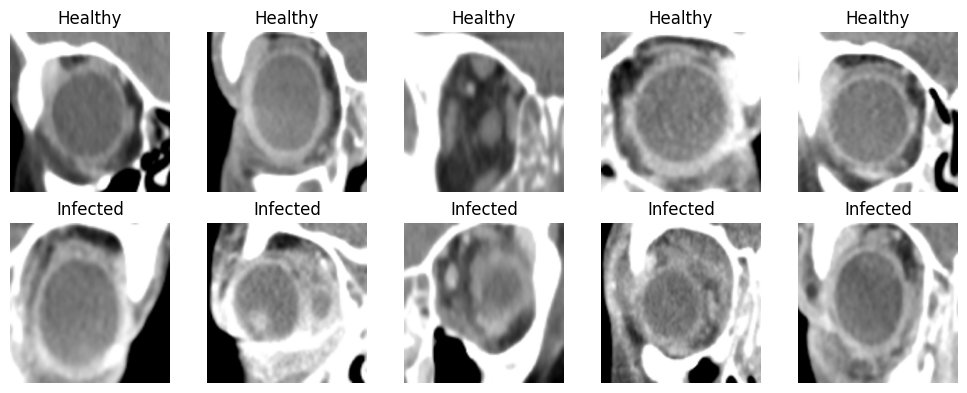

In [60]:
import matplotlib.pyplot as plt

def plot_image_samples(X, y, labels_dict, n=5):
    """
    Display samples of images from the dataset.
    """
    num_classes = len(labels_dict)
    fig, axes = plt.subplots(nrows=num_classes, ncols=n, figsize=(10, 2*num_classes))

    for i, (label, images) in enumerate(labels_dict.items()):
        class_indices = np.where(y == label)[0]
        sampled_indices = np.random.choice(class_indices, size=n, replace=False)
        
        for j, idx in enumerate(sampled_indices):
            axes[i, j].imshow(X[idx])
            axes[i, j].set_title(labels_dict[label])
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_image_samples(X_train, y_train, train_labels, n=5)




In [149]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Define the directory containing the images
image_directory = 'Abscess Stills'

# Initialize counters for left/right and orbital locations
side_count = defaultdict(int)
location_count = defaultdict(int)

# Define the possible sides and locations
sides = {'left', 'right'}
locations = {'superior', 'inferior', 'medial', 'lateral'}

# Custom legend descriptions
location_descriptions = {
    'superior': 'Superior (Roof)',
    'inferior': 'Inferior (Floor)',
    'medial': 'Medial',
    'lateral': 'Lateral'
}

# Loop through the filenames in the directory
for filename in os.listdir(image_directory):
    parts = filename.lower().split()
    
    # Check if the first part is a side or a location
    if len(parts) >= 2:
        if parts[0] in sides:
            side = parts[0]
            location = parts[1]
        elif parts[1] in sides:
            location = parts[0]
            side = parts[1]
        else:
            continue  # Skip if the naming convention doesn't match expected patterns
        
        # Increment the counters
        side_count[side] += 1
        location_count[location] += 1

# Sort the data in descending order
sorted_side_count = dict(sorted(side_count.items(), key=lambda item: item[1], reverse=True))
sorted_location_count = dict(sorted(location_count.items(), key=lambda item: item[1], reverse=True))

# Extract counts and labels for plotting sides
sides_list = list(sorted_side_count.keys())
side_counts = list(sorted_side_count.values())
total_sides = sum(side_counts)

# Extract counts and labels for plotting locations
locations_list = list(sorted_location_count.keys())
location_counts = list(sorted_location_count.values())
total_locations = sum(location_counts)


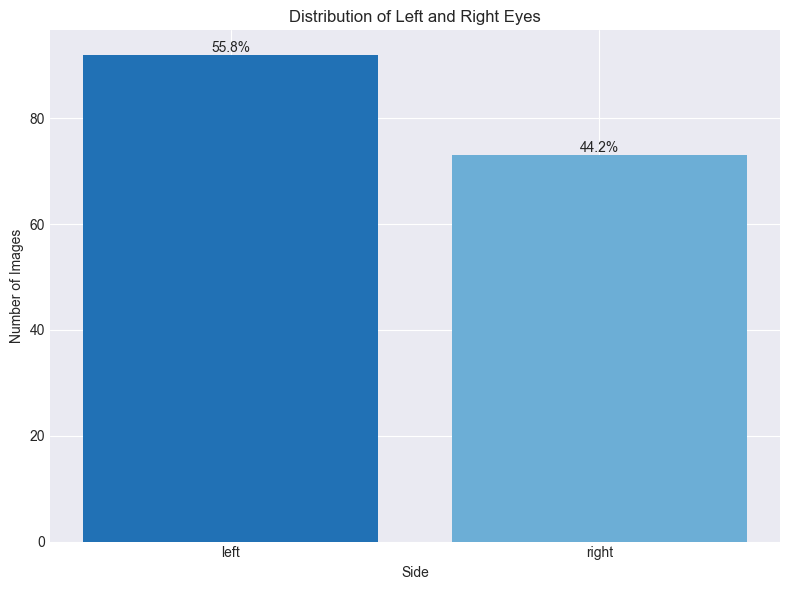

In [152]:

# Create a colormap for the bars
cmap = plt.cm.Blues_r

# Plot the distribution of left and right sides
plt.figure(figsize=(8, 6))
bars = plt.bar(np.arange(len(sides_list)), side_counts, color=cmap(np.linspace(0.25, 0.5, len(sides_list))))
plt.xticks(np.arange(len(sides_list)), sides_list)
plt.ylabel('Number of Images')
plt.xlabel('Side')
plt.title('Distribution of Left and Right Eyes')


# Add percentage labels on the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = f'{(height / total_sides) * 100:.1f}%'
    plt.text(i, height, percentage, ha='center', va='bottom')

# Save the plot as an image
plt.tight_layout()
#plt.savefig('distribution_of_sides.png')
#plt.close()
plt.show()


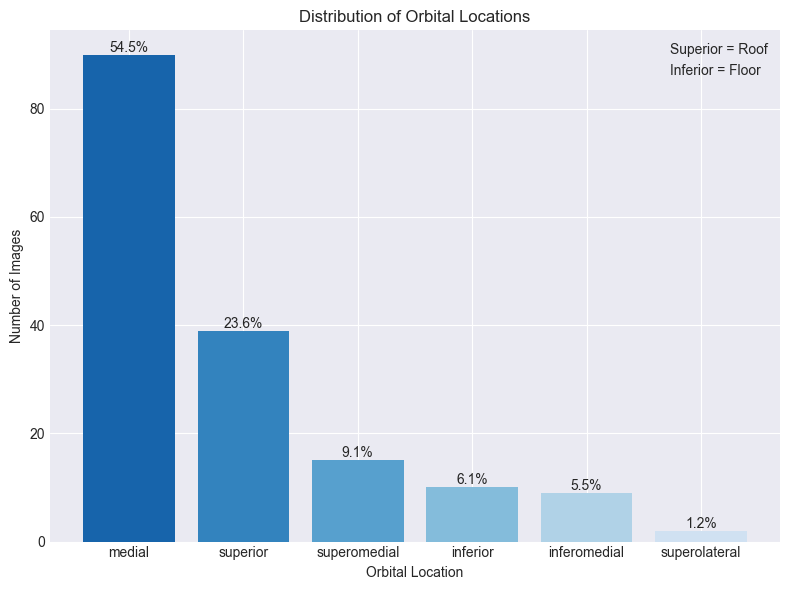

In [151]:

# Create a colormap for the bars
cmap = plt.cm.Blues_r

# Plot the distribution of orbital locations
plt.figure(figsize=(8, 6))
bars = plt.bar(np.arange(len(locations_list)), location_counts, color=cmap(np.linspace(0.2, 0.8, len(locations_list))))
plt.xticks(np.arange(len(locations_list)), locations_list)
plt.ylabel('Number of Images')
plt.xlabel('Orbital Location')
plt.title('Distribution of Orbital Locations')

# Add percentage labels on the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = f'{(height / total_locations) * 100:.1f}%'
    plt.text(i, height, percentage, ha='center', va='bottom')

# Add a custom legend
custom_legend = [
    plt.Line2D([0], [0], color='none', lw=0, label='Superior = Roof'),
    plt.Line2D([0], [0], color='none', lw=0, label='Inferior = Floor'),
]
plt.legend(handles=custom_legend, loc='upper right')

# Save the plot as an image
plt.tight_layout()
#plt.savefig('distribution_of_orbital_locations.png')
#plt.close()
plt.show()

In [3]:
# Functions to display varying Hounsfield intensity levels

def show_slice(slice):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    plt.figure()
    # slice.T & origin="lower"
    plt.imshow(slice, cmap="gray")

def show_slice_window(slice, level, window):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    plt.figure()
    # slice.T is transposing the image rotating it by 90 degrees. origin="lower" 
    # **INVESTIGATE THE PURPOSE OF THE TRANSPOSE**
    plt.imshow(slice, cmap="gray")
   #plt.savefig('L'+str(level)+'W'+str(window))


def overlay_plot(im, mask):
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)

In [ ]:
# basepath = './Images/slice*.nii.gz'
# paths = sorted(glob.glob(basepath))
# print('Images found:', len(paths))

# for c, exam_path in enumerate(paths):
#     ct_img = nib.load(exam_path)
#     ct_numpy = ct_img.get_fdata()

#     if c == 1:
#       show_slice(ct_numpy)
#       plt.savefig('original')
#       show_slice_window(ct_numpy,+50,350)
#       show_slice_window(ct_numpy,-200,2000)
#       break

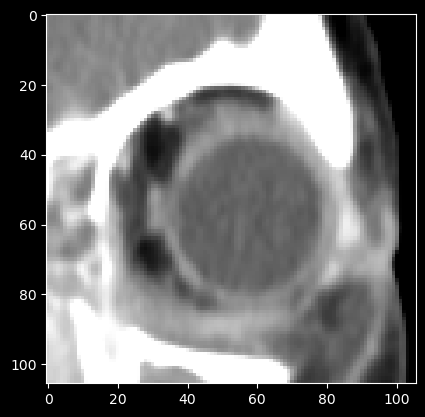

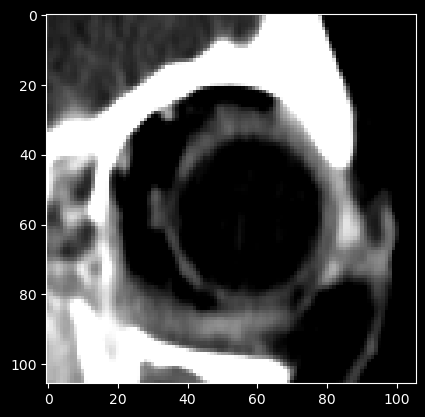

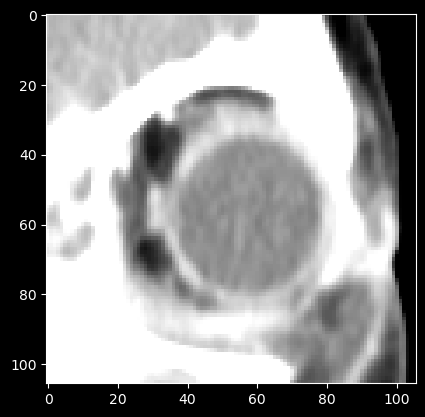

In [4]:
# Provide the path to the specific image you want to test
exam_path = 'train (copy)/Infected/Left inferior 15955.3_eye_1.png'

# input needs to be a 2D array and the images are 3D with RGB depth set
# .convert('L') converts to grayscale (2D)
img = Image.open(exam_path).convert('L')
img_numpy = np.array(img)

show_slice(img_numpy)
#plt.savefig('original.png')
show_slice_window(img_numpy, +280, 350)
# Min:200 Max: 330 w/ 25 for interval??
show_slice_window(img_numpy, +0, 350)

In [149]:
# This function has a normalizing technique added

# def show_slice_window(slice, level, window):
#     """
#     Function to process an image slice based on intensity level and window.
#     Input is a numpy 2D array.
#     """
#     max_val = level + window / 2
#     min_val = level - window / 2
#     slice = np.clip(slice, min_val, max_val)
#     slice = (slice - min_val) / (max_val - min_val) * 255  # Normalize to 0-255
#     return slice.astype(np.uint8)

In [5]:
# Without normalizing

# def show_slice_window(slice, level, window):
#     """
#     Function to apply window and level adjustments to an image slice
#     Input is a numpy 2D array
#     """
#     max = level + window/2
#     min = level - window/2
#     slice = slice.clip(min, max)
#     return slice

In [164]:
def show_slice_window(slice, level, window):
    """
    Function to apply window and level adjustments to an image slice.
    Input is a numpy 2D array.
    """
    max_val = level + window / 2
    min_val = level - window / 2
    slice = np.clip(slice, min_val, max_val)
    # Scale the slice to the range [0, 255]
    #slice = ((slice - min_val) / (max_val - min_val)) * 255
    return slice.astype(np.uint8)

def load_images_from_directory(directory):
    """
    Load images from a directory and convert them to numpy arrays.
    """
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img = Image.open(os.path.join(directory, filename)).convert('L')
            img_numpy = np.array(img)
            images.append((filename, img_numpy))
    return images


def apply_intensity_levels_to_directory(main_dir, output_dir, levels, window=350):
    """
    Generate augmented images with different intensity levels for images in subdirectories of main_dir
    and save them in output_dir.
    """
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
        
    # you will need to specify your own folder (directory) names here
    for parent_dir in ['test copy', 'train copy', 'validation copy']:
        parent_dir_path = os.path.join(main_dir, parent_dir)
        for subdir in ['Healthy', 'Infected']:
            input_subdir = os.path.join(parent_dir_path, subdir)
            output_subdir = os.path.join(output_dir, parent_dir, subdir)
            if not os.path.exists(output_subdir):
                os.makedirs(output_subdir)
            
            # Iterate over images in the input subdirectory
            for filename in os.listdir(input_subdir):
                if filename.endswith('.png') or filename.endswith('.jpg'):
                    # Load the image and convert to grayscale (convert("L"))
                    image = np.array(Image.open(os.path.join(input_subdir, filename)).convert("L"))
                    
                    # Apply intensity augmentation
                    for i, level in enumerate(levels):
                        augmented_image = show_slice_window(image, level, window)
                        
                        # Save the augmented image
                        output_filename = os.path.join(output_subdir, f'{os.path.splitext(filename)[0]}_augmented_{i}.png')
                        Image.fromarray(augmented_image).save(output_filename)

In [162]:
def display_images_from_directory(directory, disp_img=5):
    """
    Display a specified number of images from a directory using matplotlib.
    """
    images = load_images_from_directory(directory)
    num_images = len(images)
    
    if num_images == 0:
        print("No images found in the directory.")
    else:
        disp_img = min(disp_img, num_images)
        num_cols = 5
        num_rows = (disp_img + num_cols - 1) // num_cols
        
        plt.figure(figsize=(15, 15))
        for i, (filename, img) in enumerate(images[:disp_img], start=1):
            plt.subplot(num_rows, num_cols, i)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(f'{filename}')
        
        plt.tight_layout()
        plt.show()


In [165]:
main_dir = '.' # I am working out of my main directory which is ist691
output_dir = 'augmented_images' # output directory name of your choosing
intensity_levels = list(range(200, 332, 25))  # produces levels = [200, 225, 250, 275, 300, 325]

# Call the function to apply intensity augmentation to images in subdirectories and save them in the output directory
apply_intensity_levels_to_directory(main_dir, output_dir, intensity_levels)

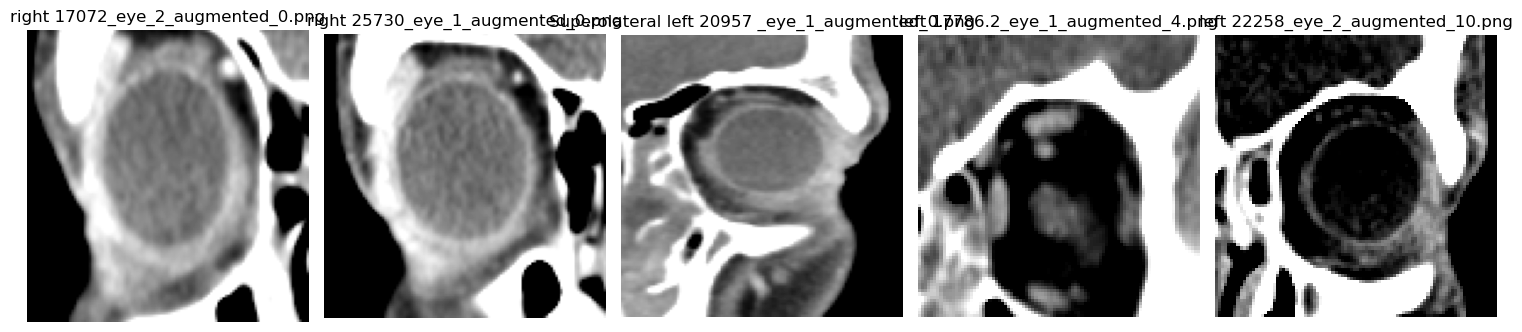

In [5]:
# default is 5 images. change disp_img parameter for more or less sample
display_images_from_directory('augmented_images/train (copy)/Healthy')

# <a id='cnn'>4. CNN Model</a>
Describe the transfer learning architecture that we are to use. VGG-16 architecture and weights usually serve as base model here.

### <a id='aug'>4.1. Data Augmentation</a>
Since the dataset is small, a technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) was used to increase the diversity of the training dataset without actually collecting new data. This is achieved by applying random transformations to the existing data. The primary goal is to improve the generalization ability of the model, reduce overfitting, and make the model more robust to variations in the data.

*** WE ALSO NEED TO MENTION THE HOUNSFIELD INTENSITY LEVEL TECHNIQUE TO ARTIFICIALLY INCREASE OUR SAMPLE. SOURCE IS
LISTED BELOW***


In [18]:
# Test Run

# img = load_img('train copy/Infected/Left medial 16266_eye_1.png')
# x = img_to_array(img)
# x = x.reshape((1,) + x.shape)

# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory

# # Remove existing 'preview' directory if it exists
# if os.path.exists('preview'):
#     shutil.rmtree('preview')

# # Create a new 'preview' directory
# os.mkdir('preview')

# # Generate batches of randomly transformed images and save the results to the `preview/` directory
# i = 0
# for batch in train_datagen.flow(x,
#                                 batch_size=1,
#                                 save_to_dir='preview',
#                                 save_prefix='aug_img',
#                                 save_format='jpeg'):
#     i += 1
#     if i > 20:
#         break  # Otherwise, the generator would loop indefinitely

In [166]:
# Apply to train, validation, and test sets.

IMG_SIZE = (224, 224)

TRAIN_DIR = 'augmented_images/train copy'
VAL_DIR = 'augmented_images/validation copy'
TEST_DIR = 'augmented_images/test copy'

"""
Here we need to adjust and play around with the parameters. This was the default values taken from model
visualizing brain tumors. The website I linked above is a good source to start.
"""

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalize pixel values to the range [0, 1] 
    rotation_range = 20,        # Randomly rotate images by up to 20 degrees
    width_shift_range = 0.2,    # Randomly shift images horizontally by up to 20% of the width
    height_shift_range = 0.2,   # Randomly shift images vertically by up to 20% of the height
    shear_range = 0.2,          # Randomly apply shearing transformations
    #brightness_range = [0.5, 1.5],
    zoom_range=0.2,             # Randomly zoom in on images
    horizontal_flip = True,     # Randomly flip images horizontally
    # I have note tried vertically flipping yet. The article I listed in references said translation
    # and shearing produced the highest performance metrics.
    vertical_flip = True,       # Randomly flip images vertically
    #The fill_mode parameter determines how newly created pixels are filled in when an image is 
    #transformed by operations such as rotation, width/height shifts, or shearing. When the 
    #transformation leads to pixel values outside the boundaries of the original image, fill_mode 
    #specifies how to fill those pixels. 
    fill_mode='nearest',        # Replaces all new pixels with the nearest existing pixel value.
    preprocessing_function = preprocess_input # Applies VGG16-specific preprocessing
)

# Data augmentation for validation (only rescaling)
# preprocess_input
validation_datagen = ImageDataGenerator(
    rescale=1.0/255, # Normalize pixel values to the range [0, 1] 
    preprocessing_function=preprocess_input
)

# Data augmentation for test
test_datagen = ImageDataGenerator(rescale=1.0/255) # IS THIS NECESSARY???

# ***Note: the below generators will not generate new images to disk. Instead, it creates augmented versions
# of the images on-the-fly during training. This means that each epoch will see different augmented versions
# of the original images

# loads training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    # is this the correct color mode we should be using?? ***INVESTIGATE***
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    seed=42
)

# loads validation data
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    # is this the correct color mode we should be using?? ***INVESTIGATE***
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    seed=42
)

# loads the test data
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,  # Specify the target size of the images
    batch_size=8,
    class_mode='binary',  # Set the class mode based on your problem (binary or categorical)
    shuffle=False  # Ensure that the data is not shuffled
)

Found 1086 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 162 images belonging to 2 classes.


In [36]:
print(train_generator.n)
print(validation_generator.n)

1080
306


### <a id='build'>4.2. Model Building</a>

In [168]:
# Load our VGG16 base model - VGG16 has been used for other medical CT imaging based on my little research. 
# We will need to research to see if other models exist
vgg16_wgt = '/Users/ryan_summers/My Documents/Python/VGG16 Weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = VGG16(
    # Test imgagenet, vgg16 weights, etc...
    weights=vgg16_wgt,
    include_top=False,
    # Must include all three dimensions height, width and channels, so we add 3 color channels (RGB).
    input_shape=IMG_SIZE + (3,))

2024-06-07 15:37:53.842123: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-06-07 15:37:53.842155: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-07 15:37:53.842172: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-07 15:37:53.842218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-07 15:37:53.842233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [179]:
"""
Here is where we can add more layers on top of the VGG16, freeze, add dropout layers, 
autoencoding, etc...
"""

# Add custom layers
x = base_model.output
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)


x = Flatten()(x)
# Dense = fully connected layer
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x) # originally 0.001
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
# dropout layer for overfitting - 0.5 describes the % of neurons to temporarily disconnect from
# previous layer
x = Dropout(0.5)(x) # increaing rate degrades performance 
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(x)  # Binary classification

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       Precision(),
                       Recall()])

# Model summary with layers, output shapes and parameters
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            6

 Total params: 21,178,689 (80.79 MB)

 Trainable params: 13,543,425 (51.66 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [180]:
# Define the step size = # of samples / batch size
step_size_train = train_generator.n // train_generator.batch_size

## Define callbacks: *** I HAVE FOUND THAT EARLY STOPPING RESULTS IN POOR PERFORMANCE ***

# EarlyStopping stops training when the validation loss doesn't improve for a specified number of epochs ("patience")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint saves the model aftere every epoch if the validation loss has improved. Saves the best version during training
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(train_generator,
                steps_per_epoch=step_size_train,
                # dataset or generator needs at least 'steps_per_epoch*epochs' batches
                epochs=50,
                validation_data=validation_generator,
                validation_steps=validation_generator.n // validation_generator.batch_size,
                callbacks=[reduce_lr, early_stopping])

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7187 - loss: 1.0964 - precision_1: 0.7371 - recall_1: 0.7329 - val_accuracy: 0.8547 - val_loss: 0.8293 - val_precision_1: 0.8590 - val_recall_1: 0.8645 - learning_rate: 1.0000e-04
Epoch 2/50
  1/135 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8750 - loss: 0.5324 - precision_1: 0.8571 - recall_1: 1.0000

2024-06-07 15:46:40.097464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:46:40.097516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_44]]
2024-06-07 15:46:40.097536: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12595925969903081686
2024-06-07 15:46:40.097542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 272760836102394279
2024-06-07 15:46:40.097546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8921706382776779202
2024-06-07 15:46:40.097554: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3014919324

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.5324 - precision_1: 0.8571 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5549 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50


2024-06-07 15:46:40.316399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:46:40.316419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-07 15:46:40.316425: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4727469120417516141
2024-06-07 15:46:40.316428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13964411322427347865
2024-06-07 15:46:40.316433: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14344402632124596874
2024-06-07 15:46:40.316436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13914025714983849348
2024-06-

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.7990 - loss: 0.7865 - precision_1: 0.7684 - recall_1: 0.8682 - val_accuracy: 0.8108 - val_loss: 0.7458 - val_precision_1: 0.7676 - val_recall_1: 0.9161 - learning_rate: 1.0000e-04
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.8750 - loss: 0.5702 - precision_1: 0.8333 - recall_1: 1.0000 - val_accuracy: 0.7500 - val_loss: 0.8002 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/50


2024-06-07 15:46:49.160945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:46:49.160959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_36]]
2024-06-07 15:46:49.160964: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8921706382776779202
2024-06-07 15:46:49.160968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8617992490721595511
2024-06-07 15:46:49.160974: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 272760836102394279
2024-06-07 15:46:49.160978: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3014919324067615826
2024-06-07 

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8604 - loss: 0.6656 - precision_1: 0.8526 - recall_1: 0.8793 - val_accuracy: 0.8412 - val_loss: 0.6976 - val_precision_1: 0.9141 - val_recall_1: 0.7647 - learning_rate: 1.0000e-04
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.8750 - loss: 0.6087 - precision_1: 1.0000 - recall_1: 0.7500 - val_accuracy: 0.7500 - val_loss: 1.4965 - val_precision_1: 1.0000 - val_recall_1: 0.6667 - learning_rate: 1.0000e-04
Epoch 7/50


2024-06-07 15:46:57.903677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:46:57.903695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add/_46]]
2024-06-07 15:46:57.903731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13265752890029090700
2024-06-07 15:46:57.903745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16579583784459336435
2024-06-07 15:46:57.903751: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1741332229963670635
2024-06-07 15:46:57.903756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 25085740769

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8417 - loss: 0.6584 - precision_1: 0.8586 - recall_1: 0.8067 - val_accuracy: 0.8953 - val_loss: 0.5730 - val_precision_1: 0.8954 - val_recall_1: 0.9013 - learning_rate: 1.0000e-04
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 1.0000 - loss: 0.4415 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5105 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 9/50


2024-06-07 15:47:06.730943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:47:06.730960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add/_46]]
2024-06-07 15:47:06.730968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14968199586369764801
2024-06-07 15:47:06.730974: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 725747919080209335
2024-06-07 15:47:06.730981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8828921376934796359
2024-06-07 15:47:06.730987: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8822173001190

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8802 - loss: 0.5681 - precision_1: 0.8699 - recall_1: 0.8992 - val_accuracy: 0.8818 - val_loss: 0.5718 - val_precision_1: 0.8659 - val_recall_1: 0.9161 - learning_rate: 2.0000e-05
Epoch 10/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.8750 - loss: 0.4907 - precision_1: 0.6667 - recall_1: 1.0000 - val_accuracy: 0.7500 - val_loss: 0.7811 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 11/50


2024-06-07 15:47:15.527130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:47:15.527153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_38]]
2024-06-07 15:47:15.527167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1741332229963670635
2024-06-07 15:47:15.527176: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8507337293955500379
2024-06-07 15:47:15.527181: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13672997545792826563
2024-06-07 15:47:15.527185: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17656384725782593616
2024-06-

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9030 - loss: 0.5403 - precision_1: 0.8765 - recall_1: 0.9408 - val_accuracy: 0.8750 - val_loss: 0.5916 - val_precision_1: 0.8589 - val_recall_1: 0.9091 - learning_rate: 2.0000e-05
Epoch 12/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.8750 - loss: 0.4695 - precision_1: 0.8000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5172 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 13/50


2024-06-07 15:47:24.215605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:47:24.215623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_44]]
2024-06-07 15:47:24.215639: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8921706382776779202
2024-06-07 15:47:24.215656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11439921636409256462
2024-06-07 15:47:24.215663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3014919324067615826
2024-06-07 15:47:24.215676: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 125959259

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9022 - loss: 0.5077 - precision_1: 0.8964 - recall_1: 0.9107 - val_accuracy: 0.8953 - val_loss: 0.6524 - val_precision_1: 0.9013 - val_recall_1: 0.8954 - learning_rate: 2.0000e-05
Epoch 14/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.7500 - loss: 0.7281 - precision_1: 0.6000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.2730 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 1.0000e-05
Epoch 15/50


2024-06-07 15:47:32.937167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:47:32.937189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_24/_54]]
2024-06-07 15:47:32.937234: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11439921636409256462
2024-06-07 15:47:32.937242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1028923709734221658
2024-06-07 15:47:32.937249: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1741332229963670635
2024-06-07 15:47:32.937254: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 850733729

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9116 - loss: 0.4983 - precision_1: 0.9111 - recall_1: 0.9237 - val_accuracy: 0.8818 - val_loss: 0.6278 - val_precision_1: 0.9034 - val_recall_1: 0.8618 - learning_rate: 1.0000e-05
Epoch 16/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.7500 - loss: 0.8535 - precision_1: 0.8333 - recall_1: 0.8333 - val_accuracy: 1.0000 - val_loss: 0.2949 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 1.0000e-05
Epoch 17/50


2024-06-07 15:47:41.732757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:47:41.732776: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8921706382776779202
2024-06-07 15:47:41.732781: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3014919324067615826
2024-06-07 15:47:41.732788: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12595925969903081686
2024-06-07 15:47:41.732791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_44]]
2024-06-07 15:47:41.732808: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 186035495

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9192 - loss: 0.4640 - precision_1: 0.9037 - recall_1: 0.9415 - val_accuracy: 0.9020 - val_loss: 0.6011 - val_precision_1: 0.9079 - val_recall_1: 0.9020 - learning_rate: 1.0000e-05
Epoch 18/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 1.0000 - loss: 0.2854 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.3404 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 1.0000e-05
Epoch 19/50


2024-06-07 15:47:50.732005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:47:50.732035: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8921706382776779202
2024-06-07 15:47:50.732042: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1028923709734221658
2024-06-07 15:47:50.732051: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12595925969903081686
2024-06-07 15:47:50.732053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Tile_2/_78]]
2024-06-07 15:47:50.732071: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18603549539041

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9155 - loss: 0.4897 - precision_1: 0.9010 - recall_1: 0.9297 - val_accuracy: 0.8851 - val_loss: 0.6056 - val_precision_1: 0.8606 - val_recall_1: 0.9281 - learning_rate: 1.0000e-05
Epoch 20/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.8750 - loss: 0.6524 - precision_1: 0.8000 - recall_1: 1.0000 - val_accuracy: 0.7500 - val_loss: 0.9253 - val_precision_1: 1.0000 - val_recall_1: 0.6667 - learning_rate: 1.0000e-05
Epoch 21/50


2024-06-07 15:47:59.708902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:47:59.708927: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8921706382776779202
2024-06-07 15:47:59.708946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add/_46]]
2024-06-07 15:47:59.708968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3014919324067615826
2024-06-07 15:47:59.708980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1741332229963670635
2024-06-07 15:47:59.708991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8507337293955

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9091 - loss: 0.4761 - precision_1: 0.8901 - recall_1: 0.9310 - val_accuracy: 0.8953 - val_loss: 0.5879 - val_precision_1: 0.8968 - val_recall_1: 0.9026 - learning_rate: 1.0000e-05
Epoch 22/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 1.0000 - loss: 0.3662 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.7500 - val_loss: 0.4478 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-05
Epoch 23/50


2024-06-07 15:48:08.677281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:48:08.677308: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12595925969903081686
2024-06-07 15:48:08.677313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_14/_68]]
2024-06-07 15:48:08.677334: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1860354953904109968
2024-06-07 15:48:08.677348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8705414848923965845
2024-06-07 15:48:08.677358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 892170638

135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9023 - loss: 0.4760 - precision_1: 0.8910 - recall_1: 0.9238 - val_accuracy: 0.8851 - val_loss: 0.6294 - val_precision_1: 0.8659 - val_recall_1: 0.9221 - learning_rate: 1.0000e-05
Epoch 24/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 1.0000 - loss: 0.2857 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.7500 - val_loss: 0.8697 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-05


2024-06-07 15:48:17.636266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 15:48:17.636294: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12595925969903081686
2024-06-07 15:48:17.636298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_3_1/dropout_1_1/add/_70]]
2024-06-07 15:48:17.636313: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1741332229963670635
2024-06-07 15:48:17.636323: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2508574076999190875
2024-06-07 15:48:17.636333: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. 

In [ ]:
step_size_train = max(train_generator.n // train_generator.batch_size, 1)
step_size_val = max(validation_generator.n // validation_generator.batch_size, 1)
print(step_size_train)
print(step_size_val)

In [171]:
#### Trying out encoding layers ####


# # Define CAE encoder layers
# def CAE_encoder(input_shape):
#     encoder_input = Input(shape=input_shape)
#     x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)
#     x = MaxPooling2D((2, 2), padding='same')(x)
#     x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2), padding='same')(x)
#     encoder_output = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
#     return Model(encoder_input, encoder_output, name="CAE_Encoder")

# # Input shape
# IMG_SIZE = (224, 224)  # Example input size, adjust as needed
# input_shape = IMG_SIZE + (3,)

# # CAE Encoder
# cae_encoder = CAE_encoder(input_shape)

# # VGG16 base model
# vgg16_wgt = 'VGG16 Weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
# base_model = VGG16(weights=vgg16_wgt, include_top=False, input_shape=IMG_SIZE + (3,))

# # Combine CAE encoder and VGG16
# input_layer = Input(shape=input_shape)
# encoded_features = cae_encoder(input_layer)
# vgg16_features = base_model(encoded_features)

# # Add custom layers
# x = Flatten()(vgg16_features)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.5)(x)
# predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(x)

# # Final model
# model = Model(inputs=input_layer, outputs=predictions)

# # Freeze the base model layers
# for layer in base_model.layers:
#     layer.trainable = False

# # Unfreeze the last few layers of the base model
# for layer in base_model.layers[-4:]:
#     layer.trainable = True

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss='binary_crossentropy',
#               metrics=['accuracy', Precision(), Recall()])

# # Model summary with layers, output shapes and parameters
# model.summary()

# # Define the step size
# step_size_train = train_generator.n // train_generator.batch_size

# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# # Train the model
# history = model.fit(train_generator,
#                     steps_per_epoch=step_size_train,
#                     epochs=50,
#                     validation_data=validation_generator,
#                     validation_steps=validation_generator.n // validation_generator.batch_size,
#                     callbacks=[reduce_lr, early_stopping])


In [ ]:
# OTHER MODEL - INCREASED DROPOUT, REDUCED OVERALL PARAMATERS.  NOT AS SUCCESSFUL.

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Reduced units
x = BatchNormalization()(x)
x = Dropout(0.6)(x)  # Increased dropout rate
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)  # Binary classification

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Compile the model
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary with layers, output shapes, and parameters
model.summary()

# Define the step size = # of samples / batch size
step_size_train = train_generator.n // train_generator.batch_size

# Define the scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[reduce_lr, model_checkpoint, lr_scheduler])

977 (61.76 MB)
Non-trainable params: 1735744 (6.62 MB)
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 21s 1s/step - loss: 0.6331 - accuracy: 0.8278 - val_loss: 2.0787 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 2/100
16/16 [==============================] - 18s 1s/step - loss: 0.4800 - accuracy: 0.8898 - val_loss: 1.6889 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/100
16/16 [==============================] - 18s 1s/step - loss: 0.3915 - accuracy: 0.9016 - val_loss: 1.1616 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 4/100
16/16 [==============================] - 16s 1s/step - loss: 0.3681 - accuracy: 0.9055 - val_loss: 1.2371 - val_accuracy: 0.7852 - lr: 1.0000e-04
Epoch 5/100
16/16 [==============================] - 16s 1s/step - loss: 0.3198 - accuracy: 0.9045 - val_loss: 3.0883 - val_accuracy: 0.6445 - lr: 1.0000e-04
Epoch 6/100
16/16 [==============================] - 17s 1s/step - loss: 0.3446 - accuracy: 0.8888 - val_loss: 1.2309 - val_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 7/100
16/16 [==============================] - 18s 1s/step - loss: 0.3054 - accuracy: 0.9085 - val_loss: 1.0460 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 8/100
16/16 [==============================] - 16s 1s/step - loss: 0.3211 - accuracy: 0.8888 - val_loss: 1.5968 - val_accuracy: 0.7930 - lr: 1.0000e-04
Epoch 9/100
16/16 [==============================] - 18s 1s/step - loss: 0.3237 - accuracy: 0.8770 - val_loss: 6.4271 - val_accuracy: 0.5156 - lr: 1.0000e-04
Epoch 10/100
16/16 [==============================] - 17s 1s/step - loss: 0.3922 - accuracy: 0.8545 - val_loss: 9.4132 - val_accuracy: 0.5234 - lr: 1.0000e-04
Epoch 11/100
16/16 [==============================] - 16s 1s/step - loss: 0.2946 - accuracy: 0.8957 - val_loss: 6.5601 - val_accuracy: 0.5117 - lr: 9.0484e-05
Epoch 12/100
16/16 [==============================] - 17s 1s/step - loss: 0.3106 - accuracy: 0.8937 - val_loss: 1.7312 - val_accuracy: 0.7070 - lr: 8.1873e-05
Epoch 13/100
16/16 [==============================] - 19s 1s/step - loss: 0.2748 - accuracy: 0.9055 - val_loss: 1.5112 - val_accuracy: 0.6953 - lr: 7.4082e-05
Epoch 14/100
16/16 [==============================] - 17s 1s/step - loss: 0.2588 - accuracy: 0.9094 - val_loss: 1.6679 - val_accuracy: 0.6680 - lr: 6.7032e-05
Epoch 15/100
16/16 [==============================] - 17s 1s/step - loss: 0.2763 - accuracy: 0.9104 - val_loss: 0.9934 - val_accuracy: 0.7734 - lr: 6.0653e-05
Epoch 16/100
16/16 [==============================] - 19s 1s/step - loss: 0.2609 - accuracy: 0.9134 - val_loss: 0.6832 - val_accuracy: 0.8047 - lr: 5.4881e-05
Epoch 17/100
16/16 [==============================] - 16s 1s/step - loss: 0.2233 - accuracy: 0.9301 - val_loss: 0.7481 - val_accuracy: 0.8359 - lr: 4.9659e-05
Epoch 18/100
16/16 [==============================] - 17s 1s/step - loss: 0.2524 - accuracy: 0.9203 - val_loss: 0.7294 - val_accuracy: 0.8203 - lr: 4.4933e-05
Epoch 19/100
16/16 [==============================] - 18s 1s/step - loss: 0.2412 - accuracy: 0.9281 - val_loss: 0.8076 - val_accuracy: 0.7969 - lr: 4.0657e-05
Epoch 20/100
16/16 [==============================] - 17s 1s/step - loss: 0.2570 - accuracy: 0.9114 - val_loss: 4.2683 - val_accuracy: 0.5273 - lr: 3.6788e-05
Epoch 21/100
16/16 [==============================] - 17s 1s/step - loss: 0.2403 - accuracy: 0.9203 - val_loss: 2.8999 - val_accuracy: 0.5742 - lr: 3.3287e-05
Epoch 22/100
16/16 [==============================] - 18s 1s/step - loss: 0.2208 - accuracy: 0.9360 - val_loss: 1.3524 - val_accuracy: 0.6836 - lr: 3.0119e-05
Epoch 23/100
16/16 [==============================] - 16s 1s/step - loss: 0.2349 - accuracy: 0.9183 - val_loss: 1.6238 - val_accuracy: 0.6719 - lr: 2.7253e-05
Epoch 24/100
16/16 [==============================] - 17s 1s/step - loss: 0.2388 - accuracy: 0.9173 - val_loss: 0.8319 - val_accuracy: 0.7930 - lr: 2.4660e-05
Epoch 25/100
16/16 [==============================] - 18s 1s/step - loss: 0.2102 - accuracy: 0.9409 - val_loss: 0.7683 - val_accuracy: 0.8125 - lr: 2.2313e-05
Epoch 26/100
16/16 [==============================] - 17s 1s/step - loss: 0.2105 - accuracy: 0.9355 - val_loss: 0.6194 - val_accuracy: 0.8398 - lr: 2.0190e-05
Epoch 27/100
16/16 [==============================] - 17s 1s/step - loss: 0.2116 - accuracy: 0.9311 - val_loss: 0.7176 - val_accuracy: 0.8203 - lr: 1.8268e-05
Epoch 28/100
16/16 [==============================] - 19s 1s/step - loss: 0.2079 - accuracy: 0.9478 - val_loss: 0.5980 - val_accuracy: 0.8477 - lr: 1.6530e-05
Epoch 29/100
16/16 [==============================] - 17s 1s/step - loss: 0.2177 - accuracy: 0.9350 - val_loss: 0.7500 - val_accuracy: 0.7930 - lr: 1.4957e-05
Epoch 30/100
16/16 [==============================] - 17s 1s/step - loss: 0.2117 - accuracy: 0.9360 - val_loss: 0.7025 - val_accuracy: 0.8086 - lr: 1.3534e-05
Epoch 31/100
16/16 [==============================] - 17s 1s/step - loss: 0.1998 - accuracy: 0.9341 - val_loss: 0.8140 - val_accuracy: 0.8125 - lr: 1.2246e-05
Epoch 32/100
16/16 [==============================] - 18s 1s/step - loss: 0.2229 - accuracy: 0.9311 - val_loss: 0.8451 - val_accuracy: 0.8242 - lr: 1.1080e-05
Epoch 33/100
16/16 [==============================] - 17s 1s/step - loss: 0.1893 - accuracy: 0.9459 - val_loss: 0.7751 - val_accuracy: 0.8164 - lr: 1.0026e-05
Epoch 34/100
16/16 [==============================] - 19s 1s/step - loss: 0.2237 - accuracy: 0.9189 - val_loss: 0.7652 - val_accuracy: 0.8203 - lr: 9.0718e-06
Epoch 35/100
16/16 [==============================] - 17s 1s/step - loss: 0.2156 - accuracy: 0.9370 - val_loss: 0.7922 - val_accuracy: 0.8203 - lr: 8.2085e-06
Epoch 36/100
16/16 [==============================] - 17s 1s/step - loss: 0.1731 - accuracy: 0.9518 - val_loss: 0.9064 - val_accuracy: 0.8086 - lr: 7.4273e-06
Epoch 37/100
16/16 [==============================] - 17s 1s/step - loss: 0.1846 - accuracy: 0.9469 - val_loss: 0.8900 - val_accuracy: 0.8086 - lr: 6.7205e-06
Epoch 38/100
16/16 [==============================] - 16s 1s/step - loss: 0.1795 - accuracy: 0.9518 - val_loss: 0.9532 - val_accuracy: 0.8086 - lr: 6.0810e-06
Epoch 39/100
16/16 [==============================] - 18s 1s/step - loss: 0.1820 - accuracy: 0.9439 - val_loss: 0.7083 - val_accuracy: 0.8320 - lr: 5.5023e-06
Epoch 40/100
16/16 [==============================] - 17s 1s/step - loss: 0.2110 - accuracy: 0.9341 - val_loss: 0.8850 - val_accuracy: 0.8047 - lr: 4.9787e-06
Epoch 41/100
16/16 [==============================] - 17s 1s/step - loss: 0.1934 - accuracy: 0.9380 - val_loss: 0.8151 - val_accuracy: 0.8164 - lr: 4.5049e-06
Epoch 42/100
16/16 [==============================] - 16s 1s/step - loss: 0.1792 - accuracy: 0.9478 - val_loss: 0.8180 - val_accuracy: 0.8203 - lr: 4.0762e-06
Epoch 43/100
16/16 [==============================] - 18s 1s/step - loss: 0.2075 - accuracy: 0.9311 - val_loss: 0.7691 - val_accuracy: 0.8242 - lr: 3.6883e-06
Epoch 44/100
16/16 [==============================] - 17s 1s/step - loss: 0.2058 - accuracy: 0.9429 - val_loss: 0.8080 - val_accuracy: 0.8242 - lr: 3.3373e-06
Epoch 45/100
16/16 [==============================] - 19s 1s/step - loss: 0.2133 - accuracy: 0.9350 - val_loss: 0.7903 - val_accuracy: 0.8164 - lr: 3.0197e-06
Epoch 46/100
16/16 [==============================] - 17s 1s/step - loss: 0.1880 - accuracy: 0.9370 - val_loss: 0.7096 - val_accuracy: 0.8203 - lr: 2.7324e-06
Epoch 47/100
16/16 [==============================] - 19s 1s/step - loss: 0.1799 - accuracy: 0.9518 - val_loss: 0.8133 - val_accuracy: 0.8164 - lr: 2.4723e-06
Epoch 48/100
16/16 [==============================] - 16s 1s/step - loss: 0.2055 - accuracy: 0.9390 - val_loss: 0.8622 - val_accuracy: 0.8086 - lr: 2.2371e-06
Epoch 49/100
16/16 [==============================] - 17s 1s/step - loss: 0.2039 - accuracy: 0.9326 - val_loss: 0.8530 - val_accuracy: 0.8203 - lr: 2.0242e-06
Epoch 50/100
16/16 [==============================] - 16s 1s/step - loss: 0.1778 - accuracy: 0.9508 - val_loss: 0.8838 - val_accuracy: 0.8203 - lr: 1.8316e-06
Epoch 51/100
16/16 [==============================] - 18s 1s/step - loss: 0.1815 - accuracy: 0.9537 - val_loss: 0.8940 - val_accuracy: 0.8164 - lr: 1.6573e-06
Epoch 52/100
16/16 [==============================] - 17s 1s/step - loss: 0.1776 - accuracy: 0.9429 - val_loss: 0.9270 - val_accuracy: 0.8008 - lr: 1.4996e-06
Epoch 53/100
16/16 [==============================] - 17s 1s/step - loss: 0.1737 - accuracy: 0.9587 - val_loss: 0.9308 - val_accuracy: 0.8164 - lr: 1.3569e-06
Epoch 54/100
16/16 [==============================] - 16s 1s/step - loss: 0.1797 - accuracy: 0.9518 - val_loss: 0.8817 - val_accuracy: 0.8164 - lr: 1.2277e-06
Epoch 55/100
16/16 [==============================] - 17s 1s/step - loss: 0.1882 - accuracy: 0.9429 - val_loss: 0.8813 - val_accuracy: 0.8047 - lr: 1.1109e-06
Epoch 56/100
16/16 [==============================] - 18s 1s/step - loss: 0.2034 - accuracy: 0.9380 - val_loss: 0.8285 - val_accuracy: 0.8281 - lr: 1.0052e-06
Epoch 57/100
16/16 [==============================] - 17s 1s/step - loss: 0.2033 - accuracy: 0.9341 - val_loss: 0.8569 - val_accuracy: 0.8086 - lr: 9.0953e-07
Epoch 58/100
16/16 [==============================] - 16s 1s/step - loss: 0.1802 - accuracy: 0.9518 - val_loss: 0.8034 - val_accuracy: 0.8203 - lr: 8.2297e-07
Epoch 59/100
16/16 [==============================] - 18s 1s/step - loss: 0.1827 - accuracy: 0.9449 - val_loss: 0.8566 - val_accuracy: 0.8398 - lr: 7.4466e-07
Epoch 60/100
16/16 [==============================] - 17s 1s/step - loss: 0.2022 - accuracy: 0.9429 - val_loss: 0.9673 - val_accuracy: 0.7969 - lr: 6.7379e-07
Epoch 61/100
16/16 [==============================] - 17s 1s/step - loss: 0.1881 - accuracy: 0.9429 - val_loss: 0.8633 - val_accuracy: 0.8164 - lr: 6.0967e-07
Epoch 62/100
16/16 [==============================] - 18s 1s/step - loss: 0.1647 - accuracy: 0.9518 - val_loss: 0.8797 - val_accuracy: 0.8164 - lr: 5.5165e-07
Epoch 63/100
16/16 [==============================] - 17s 1s/step - loss: 0.1954 - accuracy: 0.9409 - val_loss: 0.9234 - val_accuracy: 0.8125 - lr: 4.9916e-07
Epoch 64/100
16/16 [==============================] - 17s 1s/step - loss: 0.2075 - accuracy: 0.9336 - val_loss: 0.9140 - val_accuracy: 0.8281 - lr: 4.5166e-07
Epoch 65/100
16/16 [==============================] - 17s 1s/step - loss: 0.1674 - accuracy: 0.9626 - val_loss: 0.9140 - val_accuracy: 0.8086 - lr: 4.0868e-07
Epoch 66/100
16/16 [==============================] - 16s 1s/step - loss: 0.1940 - accuracy: 0.9380 - val_loss: 0.8186 - val_accuracy: 0.8242 - lr: 3.6979e-07
Epoch 67/100
16/16 [==============================] - 17s 1s/step - loss: 0.2088 - accuracy: 0.9370 - val_loss: 0.8717 - val_accuracy: 0.8242 - lr: 3.3460e-07
Epoch 68/100
16/16 [==============================] - 18s 1s/step - loss: 0.1821 - accuracy: 0.9449 - val_loss: 0.8122 - val_accuracy: 0.8203 - lr: 3.0275e-07
Epoch 69/100
16/16 [==============================] - 16s 1s/step - loss: 0.1834 - accuracy: 0.9449 - val_loss: 0.7861 - val_accuracy: 0.8320 - lr: 2.7394e-07
Epoch 70/100
16/16 [==============================] - 17s 1s/step - loss: 0.1923 - accuracy: 0.9360 - val_loss: 0.8181 - val_accuracy: 0.8164 - lr: 2.4787e-07
Epoch 71/100
16/16 [==============================] - 16s 1s/step - loss: 0.1746 - accuracy: 0.9429 - val_loss: 0.8341 - val_accuracy: 0.8203 - lr: 2.2429e-07
Epoch 72/100
16/16 [==============================] - 16s 1s/step - loss: 0.1820 - accuracy: 0.9508 - val_loss: 0.9093 - val_accuracy: 0.8047 - lr: 2.0294e-07
Epoch 73/100
16/16 [==============================] - 17s 1s/step - loss: 0.1827 - accuracy: 0.9459 - val_loss: 0.7989 - val_accuracy: 0.8281 - lr: 1.8363e-07
Epoch 74/100
16/16 [==============================] - 17s 1s/step - loss: 0.1990 - accuracy: 0.9390 - val_loss: 0.8694 - val_accuracy: 0.8164 - lr: 1.6616e-07
Epoch 75/100
16/16 [==============================] - 17s 1s/step - loss: 0.1933 - accuracy: 0.9449 - val_loss: 0.7843 - val_accuracy: 0.8203 - lr: 1.5034e-07
Epoch 76/100
16/16 [==============================] - 17s 1s/step - loss: 0.1785 - accuracy: 0.9498 - val_loss: 0.8206 - val_accuracy: 0.8125 - lr: 1.3604e-07
Epoch 77/100
16/16 [==============================] - 18s 1s/step - loss: 0.1839 - accuracy: 0.9400 - val_loss: 0.9044 - val_accuracy: 0.8203 - lr: 1.2309e-07
Epoch 78/100
16/16 [==============================] - 16s 1s/step - loss: 0.2022 - accuracy: 0.9331 - val_loss: 0.8804 - val_accuracy: 0.8125 - lr: 1.1138e-07
Epoch 79/100
16/16 [==============================] - 17s 1s/step - loss: 0.1968 - accuracy: 0.9370 - val_loss: 0.9191 - val_accuracy: 0.8008 - lr: 1.0078e-07
Epoch 80/100
16/16 [==============================] - 17s 1s/step - loss: 0.2145 - accuracy: 0.9390 - val_loss: 0.8430 - val_accuracy: 0.8164 - lr: 9.1188e-08
Epoch 81/100
16/16 [==============================] - 17s 1s/step - loss: 0.1625 - accuracy: 0.9587 - val_loss: 0.8763 - val_accuracy: 0.8203 - lr: 8.2510e-08
Epoch 82/100
16/16 [==============================] - 17s 1s/step - loss: 0.1791 - accuracy: 0.9518 - val_loss: 0.8539 - val_accuracy: 0.8164 - lr: 7.4658e-08
Epoch 83/100
16/16 [==============================] - 16s 1s/step - loss: 0.2193 - accuracy: 0.9380 - val_loss: 0.8227 - val_accuracy: 0.8203 - lr: 6.7554e-08
Epoch 84/100
16/16 [==============================] - 16s 1s/step - loss: 0.1910 - accuracy: 0.9498 - val_loss: 0.8249 - val_accuracy: 0.8242 - lr: 6.1125e-08
Epoch 85/100
16/16 [==============================] - 18s 1s/step - loss: 0.1901 - accuracy: 0.9419 - val_loss: 0.8867 - val_accuracy: 0.8164 - lr: 5.5308e-08
Epoch 86/100
16/16 [==============================] - 17s 1s/step - loss: 0.1688 - accuracy: 0.9518 - val_loss: 0.8195 - val_accuracy: 0.8203 - lr: 5.0045e-08
Epoch 87/100
16/16 [==============================] - 16s 1s/step - loss: 0.1755 - accuracy: 0.9557 - val_loss: 0.8445 - val_accuracy: 0.8203 - lr: 4.5283e-08
Epoch 88/100
16/16 [==============================] - 16s 1s/step - loss: 0.2110 - accuracy: 0.9370 - val_loss: 0.8313 - val_accuracy: 0.8320 - lr: 4.0973e-08
Epoch 89/100
16/16 [==============================] - 17s 1s/step - loss: 0.2025 - accuracy: 0.9449 - val_loss: 0.8207 - val_accuracy: 0.8281 - lr: 3.7074e-08
Epoch 90/100
16/16 [==============================] - 16s 997ms/step - loss: 0.2107 - accuracy: 0.9281 - val_loss: 0.8675 - val_accuracy: 0.8164 - lr: 3.3546e-08
Epoch 91/100
16/16 [==============================] - 19s 1s/step - loss: 0.1931 - accuracy: 0.9449 - val_loss: 0.8518 - val_accuracy: 0.8125 - lr: 3.0354e-08
Epoch 92/100
16/16 [==============================] - 16s 996ms/step - loss: 0.1835 - accuracy: 0.9459 - val_loss: 0.8283 - val_accuracy: 0.8242 - lr: 2.7465e-08
Epoch 93/100
16/16 [==============================] - 16s 1s/step - loss: 0.2082 - accuracy: 0.9429 - val_loss: 0.8277 - val_accuracy: 0.8281 - lr: 2.4852e-08
Epoch 94/100
16/16 [==============================] - 17s 1s/step - loss: 0.2055 - accuracy: 0.9360 - val_loss: 0.7943 - val_accuracy: 0.8281 - lr: 2.2487e-08
Epoch 95/100
16/16 [==============================] - 17s 1s/step - loss: 0.1866 - accuracy: 0.9380 - val_loss: 0.8035 - val_accuracy: 0.8281 - lr: 2.0347e-08
Epoch 96/100
16/16 [==============================] - 16s 1s/step - loss: 0.1859 - accuracy: 0.9449 - val_loss: 0.7970 - val_accuracy: 0.8242 - lr: 1.8410e-08
Epoch 97/100
16/16 [==============================] - 16s 999ms/step - loss: 0.1898 - accuracy: 0.9478 - val_loss: 0.9351 - val_accuracy: 0.8125 - lr: 1.6659e-08
Epoch 98/100
16/16 [==============================] - 16s 1s/step - loss: 0.1811 - accuracy: 0.9390 - val_loss: 0.8443 - val_accuracy: 0.8203 - lr: 1.5073e-08
Epoch 99/100
16/16 [==============================] - 17s 1s/step - loss: 0.1638 - accuracy: 0.9577 - val_loss: 0.8780 - val_accuracy: 0.8281 - lr: 1.3639e-08
Epoch 100/100
16/16 [==============================] - 17s 1s/step - loss: 0.1937 - accuracy: 0.9469 - val_loss: 0.8556 - val_accuracy: 0.8242 - lr: 1.2341e-08

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

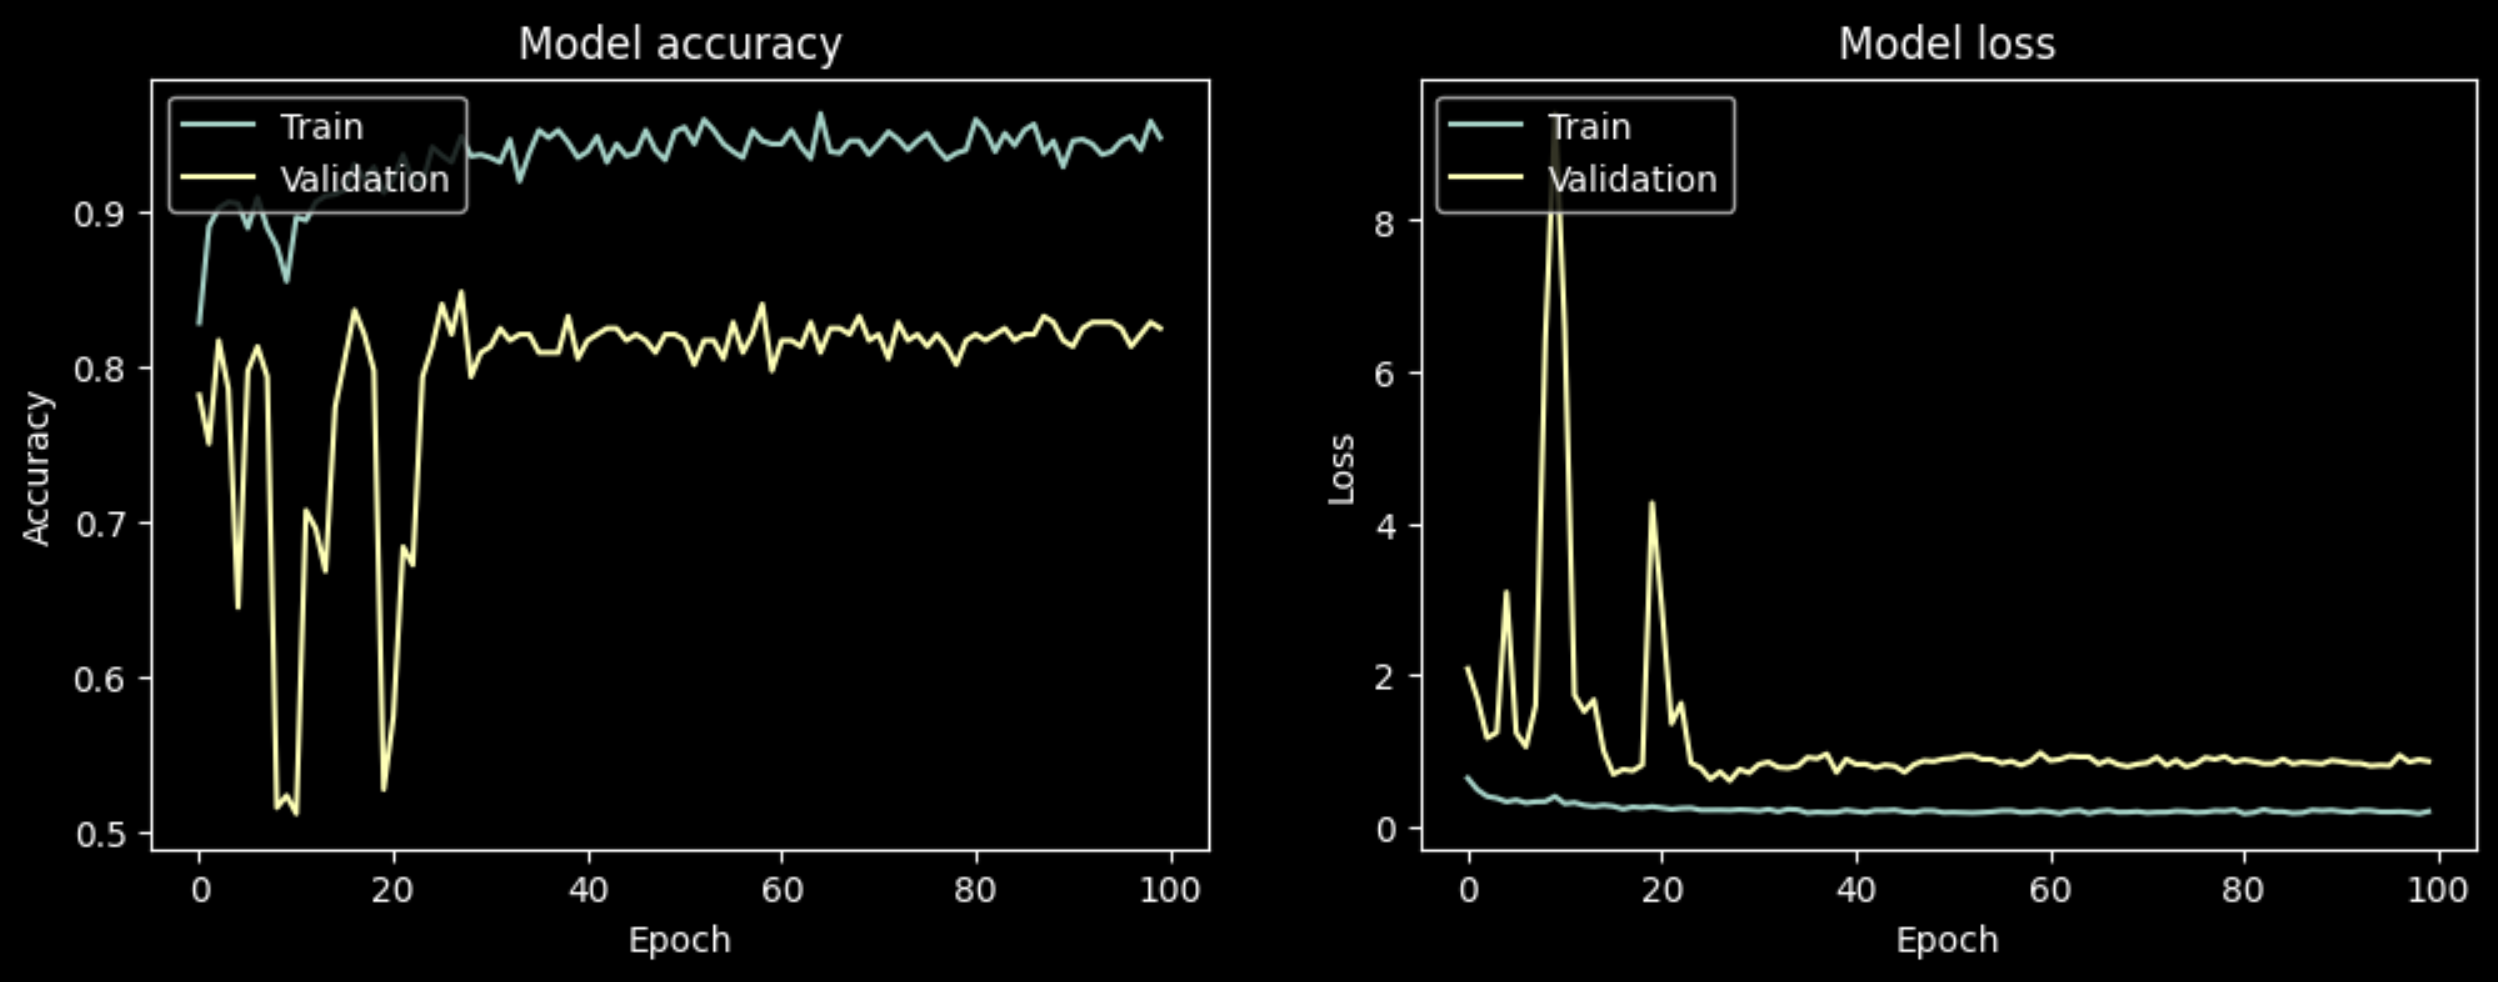

In [ ]:
# OTHER MODEL - TRIED DIFFERENT BATCH SIZES - NOT AS SUCCESSFUL

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Update these paths to the actual directories of your data
train_data_dir = '/content/augmented_images/train copy'
validation_data_dir = '/content/augmented_images/validation copy'

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,  # smaller batch size
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

# Define the step size = # of samples / batch size
step_size_train = train_generator.n // train_generator.batch_size

# Define the scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Reduced units
x = BatchNormalization()(x)
x = Dropout(0.6)(x)  # Increased dropout rate
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)  # Binary classification

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Compile the model
optimizer = Adam(learning_rate=0.0005, clipvalue=1.0)  # Reduced learning rate
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[reduce_lr, model_checkpoint, lr_scheduler, early_stopping])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Found 1080 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Epoch 1/50
33/33 [==============================] - 23s 559ms/step - loss: 0.8333 - accuracy: 0.6613 - val_loss: 11.4898 - val_accuracy: 0.4901 - lr: 5.0000e-04
Epoch 2/50
33/33 [==============================] - 18s 557ms/step - loss: 0.7348 - accuracy: 0.6737 - val_loss: 1.4413 - val_accuracy: 0.4934 - lr: 5.0000e-04
Epoch 3/50
33/33 [==============================] - 17s 524ms/step - loss: 0.7774 - accuracy: 0.6574 - val_loss: 7.8907 - val_accuracy: 0.4901 - lr: 5.0000e-04
Epoch 4/50
33/33 [==============================] - 18s 534ms/step - loss: 0.7184 - accuracy: 0.6431 - val_loss: 2.6352 - val_accuracy: 0.4868 - lr: 5.0000e-04
Epoch 5/50
33/33 [==============================] - 17s 511ms/step - loss: 0.6592 - accuracy: 0.7185 - val_loss: 3.3060 - val_accuracy: 0.4901 - lr: 5.0000e-04
Epoch 6/50
33/33 [==============================] - 17s 516ms/step - loss: 0.6524 - accuracy: 0.7090 - val_loss: 2.3187 - val_accuracy: 0.4934 - lr: 5.0000e-04
Epoch 7/50
33/33 [==============================] - 19s 559ms/step - loss: 0.6624 - accuracy: 0.7300 - val_loss: 1.2869 - val_accuracy: 0.5888 - lr: 5.0000e-04
Epoch 8/50
33/33 [==============================] - 18s 533ms/step - loss: 0.5946 - accuracy: 0.7395 - val_loss: 2.5694 - val_accuracy: 0.4934 - lr: 5.0000e-04
Epoch 9/50
33/33 [==============================] - 18s 559ms/step - loss: 0.6052 - accuracy: 0.7576 - val_loss: 0.9943 - val_accuracy: 0.6184 - lr: 5.0000e-04
Epoch 10/50
33/33 [==============================] - 19s 564ms/step - loss: 0.6058 - accuracy: 0.7405 - val_loss: 0.9598 - val_accuracy: 0.5099 - lr: 5.0000e-04
Epoch 11/50
33/33 [==============================] - 19s 561ms/step - loss: 0.5798 - accuracy: 0.7347 - val_loss: 0.6534 - val_accuracy: 0.6842 - lr: 4.5242e-04
Epoch 12/50
33/33 [==============================] - 18s 549ms/step - loss: 0.5584 - accuracy: 0.7605 - val_loss: 0.8430 - val_accuracy: 0.6118 - lr: 4.0937e-04
Epoch 13/50
33/33 [==============================] - 19s 558ms/step - loss: 0.5566 - accuracy: 0.7729 - val_loss: 1.3830 - val_accuracy: 0.5296 - lr: 3.7041e-04
Epoch 14/50
33/33 [==============================] - 17s 507ms/step - loss: 0.5555 - accuracy: 0.7815 - val_loss: 0.7481 - val_accuracy: 0.6711 - lr: 3.3516e-04
Epoch 15/50
33/33 [==============================] - 17s 510ms/step - loss: 0.4862 - accuracy: 0.8006 - val_loss: 1.5893 - val_accuracy: 0.5230 - lr: 3.0327e-04
Epoch 16/50
33/33 [==============================] - 18s 546ms/step - loss: 0.4949 - accuracy: 0.7948 - val_loss: 0.6812 - val_accuracy: 0.6842 - lr: 2.7441e-04
Epoch 17/50
33/33 [==============================] - 18s 536ms/step - loss: 0.4858 - accuracy: 0.7968 - val_loss: 0.4761 - val_accuracy: 0.7928 - lr: 2.4829e-04
Epoch 18/50
33/33 [==============================] - 17s 512ms/step - loss: 0.4737 - accuracy: 0.8216 - val_loss: 0.5045 - val_accuracy: 0.7599 - lr: 2.2466e-04
Epoch 19/50
33/33 [==============================] - 17s 528ms/step - loss: 0.4647 - accuracy: 0.8130 - val_loss: 0.4701 - val_accuracy: 0.8289 - lr: 2.0328e-04
Epoch 20/50
33/33 [==============================] - 18s 537ms/step - loss: 0.4374 - accuracy: 0.8168 - val_loss: 0.4433 - val_accuracy: 0.7993 - lr: 1.8394e-04
Epoch 21/50
33/33 [==============================] - 18s 547ms/step - loss: 0.4401 - accuracy: 0.8120 - val_loss: 0.4425 - val_accuracy: 0.8191 - lr: 1.6644e-04
Epoch 22/50
33/33 [==============================] - 17s 524ms/step - loss: 0.4247 - accuracy: 0.8321 - val_loss: 0.5050 - val_accuracy: 0.7862 - lr: 1.5060e-04
Epoch 23/50
33/33 [==============================] - 17s 529ms/step - loss: 0.3708 - accuracy: 0.8588 - val_loss: 0.4465 - val_accuracy: 0.8059 - lr: 1.3627e-04
Epoch 24/50
33/33 [==============================] - 17s 521ms/step - loss: 0.3698 - accuracy: 0.8492 - val_loss: 0.4729 - val_accuracy: 0.7993 - lr: 1.2330e-04
Epoch 25/50
33/33 [==============================] - 17s 528ms/step - loss: 0.3382 - accuracy: 0.8779 - val_loss: 0.6962 - val_accuracy: 0.7434 - lr: 1.1156e-04
Epoch 26/50
33/33 [==============================] - 17s 505ms/step - loss: 0.3449 - accuracy: 0.8702 - val_loss: 0.5617 - val_accuracy: 0.7434 - lr: 1.0095e-04
Epoch 27/50
33/33 [==============================] - 17s 506ms/step - loss: 0.3701 - accuracy: 0.8569 - val_loss: 0.5165 - val_accuracy: 0.7928 - lr: 9.1342e-05
Epoch 28/50
33/33 [==============================] - 17s 526ms/step - loss: 0.3493 - accuracy: 0.8616 - val_loss: 0.6247 - val_accuracy: 0.7961 - lr: 8.2649e-05
Epoch 29/50
33/33 [==============================] - 20s 587ms/step - loss: 0.3427 - accuracy: 0.8635 - val_loss: 0.5332 - val_accuracy: 0.7500 - lr: 7.4784e-05
Epoch 30/50
33/33 [==============================] - 17s 523ms/step - loss: 0.3366 - accuracy: 0.8779 - val_loss: 0.6027 - val_accuracy: 0.7336 - lr: 6.7668e-05
Epoch 31/50
33/33 [==============================] - 17s 527ms/step - loss: 0.2967 - accuracy: 0.22 - val_loss: 0.5504 - val_accuracy: 0.8059 - lr: 6.1228e-05



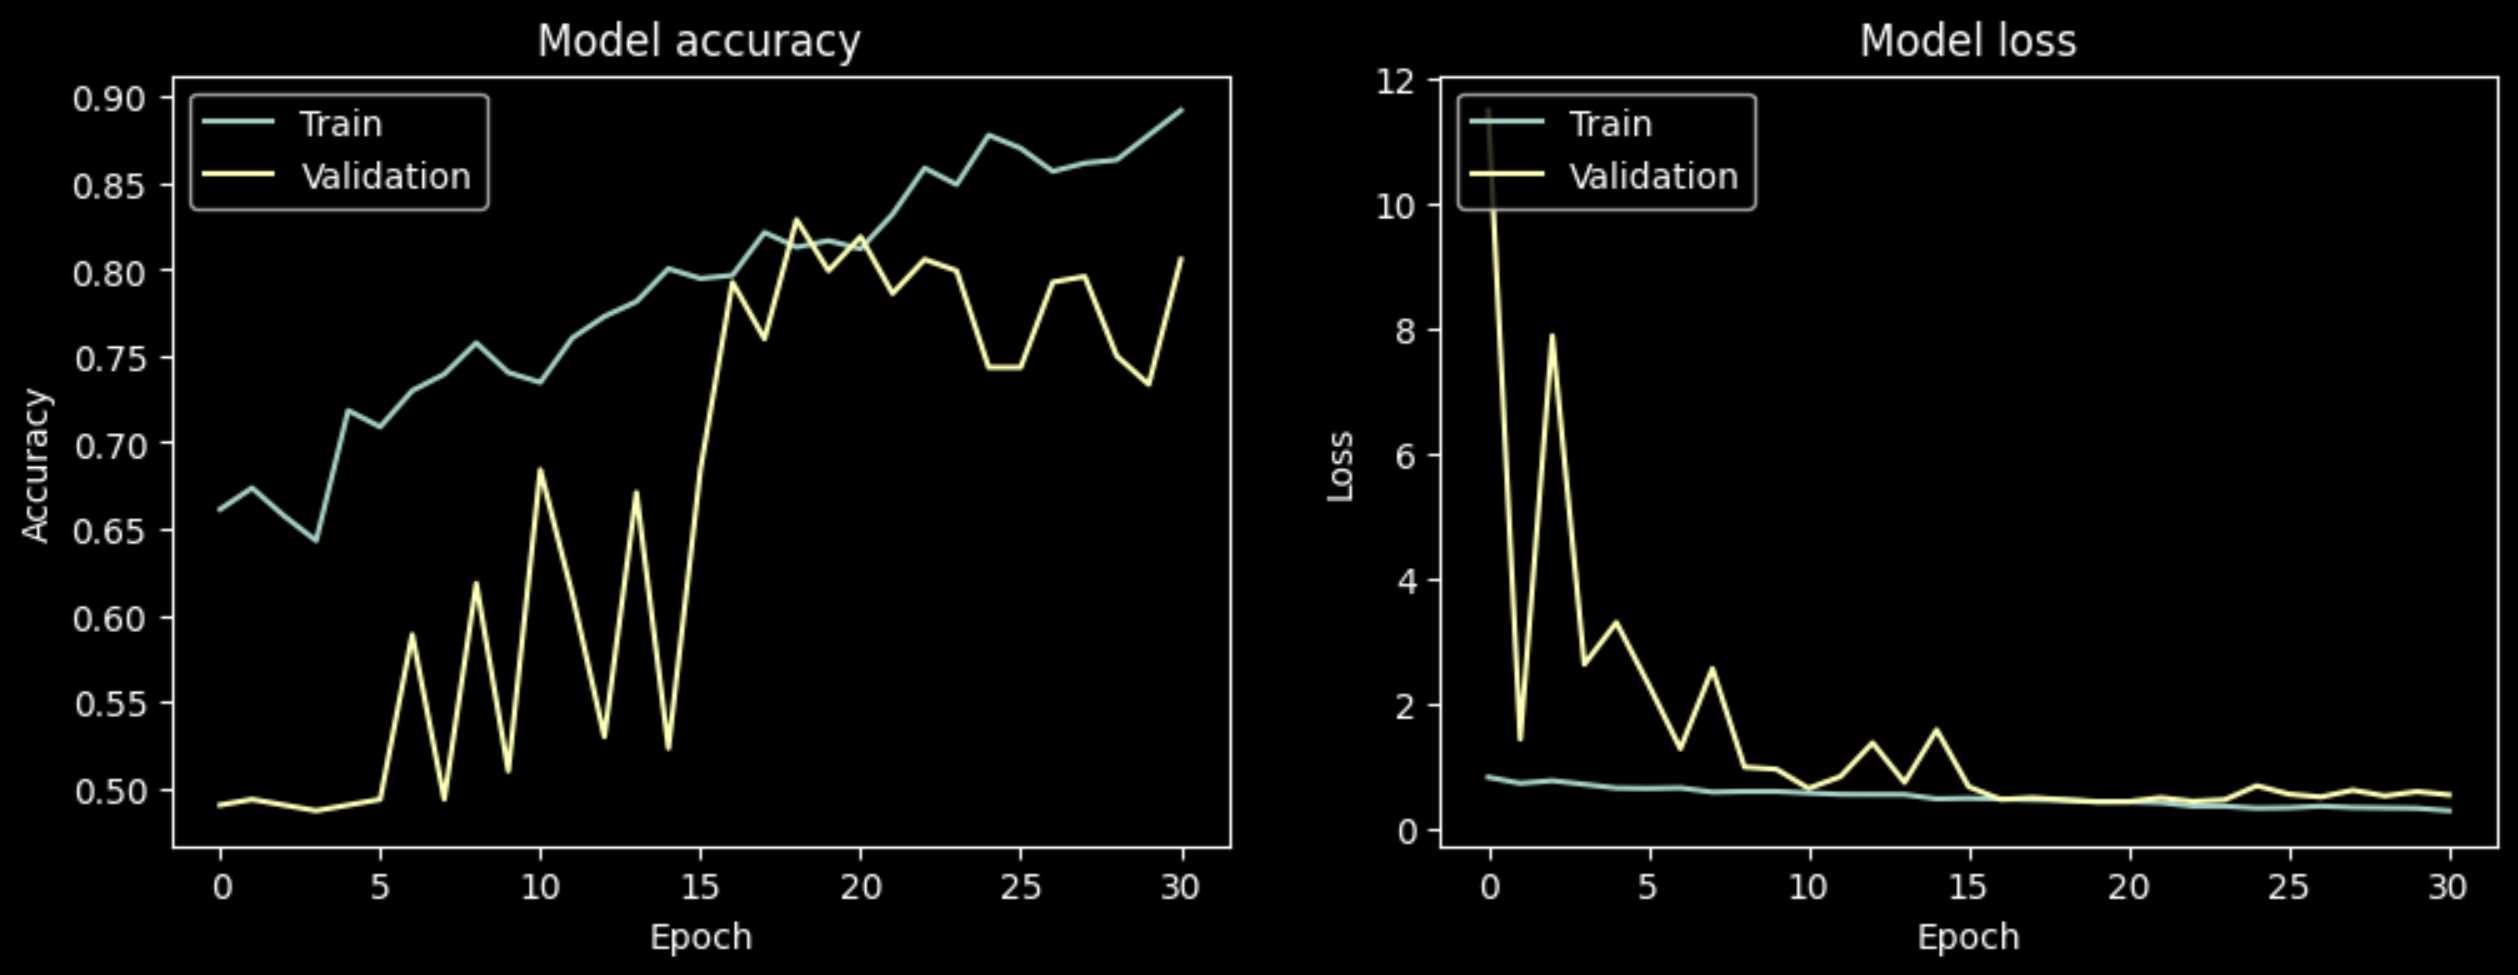

### <a id='perf'>4.3. Model Performance</a>

In [7]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])

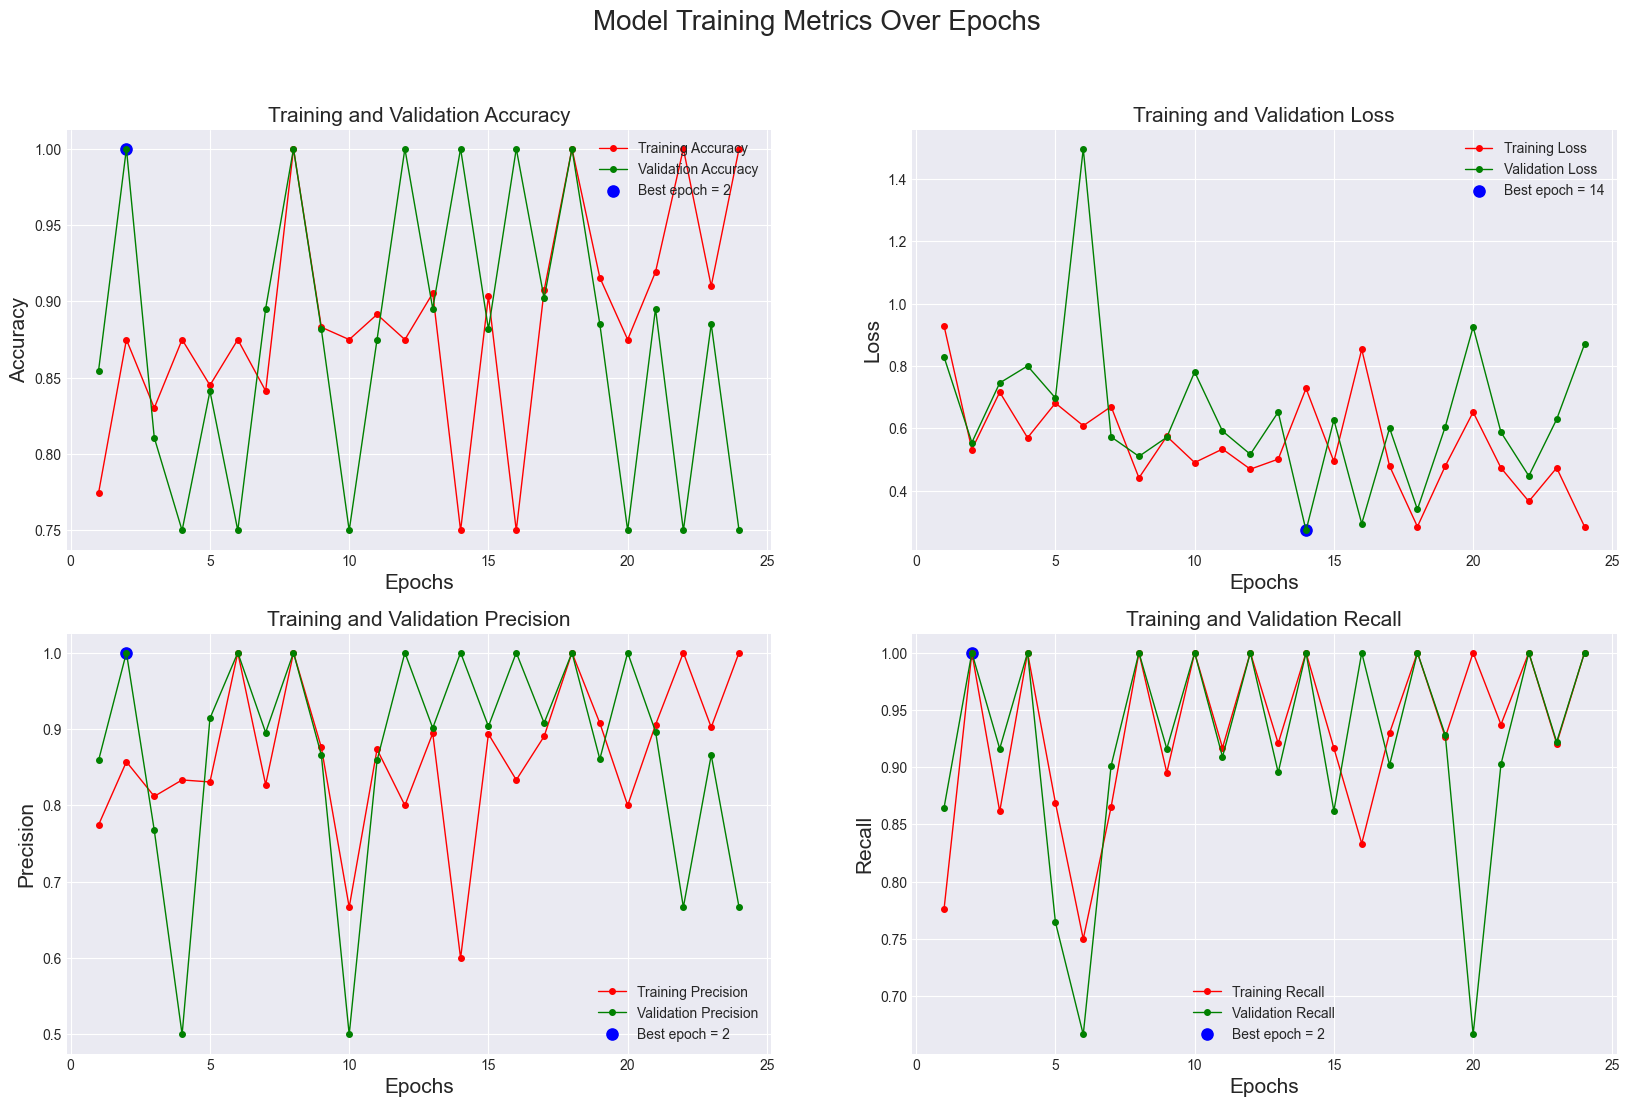

In [188]:
# Extract history data
metrics = ['accuracy', 'loss', 'precision', 'recall']
history_data = {}
val_metrics = {}
for metric in metrics:
    # Find the matching key for the metric
    metric_key = next((key for key in history.history.keys() 
                       if metric in key and not key.startswith('val_')), None)
    val_metric_key = next((key for key in history.history.keys() 
                           if metric in key and key.startswith('val_')), None)
    if metric_key:
        history_data[metric] = history.history[metric_key]
    if val_metric_key:
        val_metrics[f'val_{metric}'] = history.history[val_metric_key]

# Determine best epochs
best_epochs = {metric: np.argmax(val_metrics[f'val_{metric}'])
               if metric != 'loss' else np.argmin(val_metrics[f'val_loss']) for metric in metrics}
best_values = {metric: val_metrics[f'val_{metric}'][best_epochs[metric]] for metric in metrics}

# Epochs list
epochs = list(range(1, len(history_data['accuracy']) + 1))

# Plotting setup
plt.figure(figsize=(20, 12))

# Plot each metric
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(epochs, history_data[metric], 'r-o', label=f'Training {metric.capitalize()}', linewidth=1, markersize=4)
    plt.plot(epochs, val_metrics[f'val_{metric}'], 'g-o', label=f'Validation {metric.capitalize()}', linewidth=1, markersize=4)
    plt.scatter(best_epochs[metric] + 1, best_values[metric], s=65, c='blue', label=f'Best epoch = {best_epochs[metric] + 1}')
    plt.title(f'Training and Validation {metric.capitalize()}', fontsize=15)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel(metric.capitalize(), fontsize=15)
    plt.legend()

plt.suptitle('Model Training Metrics Over Epochs', fontsize=20)
plt.show()

In [189]:
# Save the current Model
#model.save("./my_model/saved_model2.h5")
#model.save('./my_model/saved_model2.keras')

# Retrieve final loss and accuracy
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]  # Replace 'accuracy' with 'acc' if you're using that metric
validation_loss = history.history['val_loss'][-1]
validation_accuracy = history.history['val_accuracy'][-1]  # Replace 'val_accuracy' with 'val_acc' if you're using that metric

print(f'Final Training Loss: {final_loss:.4f}')
print(f'Final Training Accuracy: {final_accuracy:.4f}')
print('-' * 34)
print(f'Final Validation Loss: {validation_loss:.4f}')
print(f'Final Validation Accuracy: {validation_accuracy:.4f}')

Final Training Loss: 0.2857
Final Training Accuracy: 1.0000
----------------------------------
Final Validation Loss: 0.8697
Final Validation Accuracy: 0.7500


In [190]:
# Evaluate on the test set
# Load the trained model
#model = keras.models.load_model('saved_model.h5')

"""
Evaluation metrics will be different because the trained model is fed forward to obtain 
results on the test dataset. The main difference between training (fit) and test (evaluate) 
is that the former computes the feed forward step on the NN and then updates the weights via
back-propagation while the latter only does the first part. Metrics on the .fit() are 
calculated after the feed froward but before back-propagation. 
"""

tr_score = model.evaluate(train_generator, verbose=1)
valid_score = model.evaluate(validation_generator, verbose=1)
test_score = model.evaluate(test_generator, verbose=1)

print()
print(f"Train Loss: {tr_score[0]:.4f}")
print(f"Train Accuracy: {tr_score[1]*100:.2f}%")
print('-' * 30)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 30)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9105 - loss: 0.4884 - precision_1: 0.8985 - recall_1: 0.9269
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9137 - loss: 0.5793 - precision_1: 0.8994 - recall_1: 0.9409
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8276 - loss: 0.9940 - precision_1: 0.3866 - recall_1: 0.4513

Train Loss: 0.5094
Train Accuracy: 90.24%
------------------------------
Validation Loss: 0.6490
Validation Accuracy: 89.67%
------------------------------
Test Loss: 1.0383
Test Accuracy: 82.10%


In [86]:
test_score

[0.8617398142814636,
 0.790123462677002,
 0.7820512652397156,
 0.7820512652397156,
 array([0.65], dtype=float32)]

In [176]:
# Performance Metrics
print(f"Train Recall: {tr_score[3]:.4f}")
print(f"Valid Recall: {valid_score[3]:.4f}")
print(f"Test Recall: {test_score[3]:.4f}")
print('-' * 30)
print(f"Train Precision: {tr_score[2]:.4f}")
print(f"Valid Precision: {valid_score[2]:.4f}")
print(f"Test Precision: {test_score[2]:.4f}")

# Define the F1 score calculation function
def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 / (1/precision + 1/recall)

# Calculate and print F1 scores
train_f1 = calculate_f1_score(tr_score[2], tr_score[3])
valid_f1 = calculate_f1_score(valid_score[2], valid_score[3])
test_f1 = calculate_f1_score(test_score[2], test_score[3])

print('-' * 30)
print(f"Train F1 Score: {train_f1:.4f}")
print(f"Valid F1 Score: {valid_f1:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Train Recall: 0.8791
Valid Recall: 0.8333
Test Recall: 0.7179
------------------------------
Train Precision: 0.8602
Valid Precision: 0.8497
Test Precision: 0.7671
------------------------------
Train F1 Score: 0.8696
Valid F1 Score: 0.8414
Test F1 Score: 0.7417


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
[[73 11]
 [18 60]]


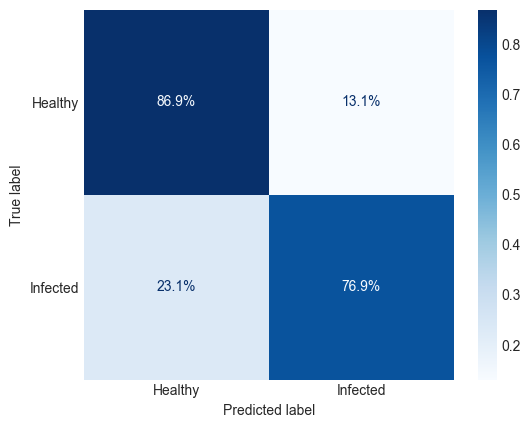

In [185]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Predictions are from the test generator object
preds = model.predict(test_generator)
# Sigmoid function produces a single output (0,1) so we want to round our results
y_pred = np.round(preds)
#y_pred = np.round(y_pred).tolist()
# Class labels (Healthy & Infected)
labels = list(train_generator.class_indices.keys())

cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

# Normalize=True = provides insights into the proportions of correct 
# predictions relative to the True class distribution
disp = ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred,
                                               display_labels=labels,
                                               normalize='true',
                                               cmap=plt.cm.Blues,
                                               values_format='.1%') #.4f
plt.grid(False)
plt.show()



In [186]:
# Classification Report
clr = classification_report(test_generator.classes, y_pred, digits=4)
print(clr)

              precision    recall  f1-score   support

           0     0.8022    0.8690    0.8343        84
           1     0.8451    0.7692    0.8054        78

    accuracy                         0.8210       162
   macro avg     0.8236    0.8191    0.8198       162
weighted avg     0.8228    0.8210    0.8204       162



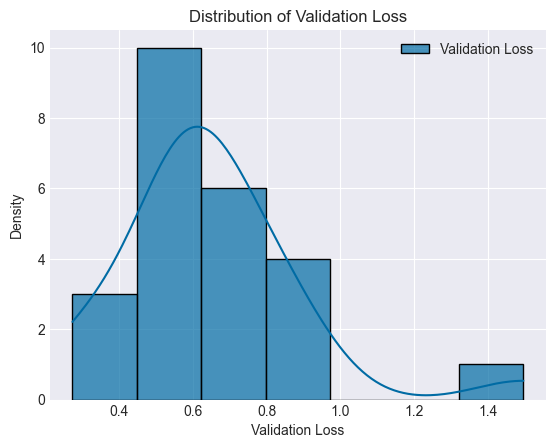

In [187]:
import warnings
import seaborn as sns

# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", message="When grouping with a length-1 list-like")

validation_loss = history.history['val_loss']
validation_loss_df = pd.DataFrame(validation_loss, columns=['Validation Loss'])

sns.histplot(validation_loss_df, kde=True, color='blue', alpha=0.7, bins=7)
plt.xlabel('Validation Loss')
plt.ylabel('Density')
plt.title('Distribution of Validation Loss')
plt.show()

In [23]:
import openpyxl

"""
This code outputs the loss values for every image into an excel file so we can see which
images the model is struggling with
"""

output_dir = 'saved_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize BinaryCrossentropy object
bce = BinaryCrossentropy()

# Lists to store results
batch_indices = []
sample_indices = []
predictions = []
true_labels = []
losses = []
image_paths = []

# Iterate over the validation dataset
for batch_index, (x_val, y_val) in enumerate(validation_generator):
    # Get model predictions for the current batch
    y_pred = model.predict(x_val)

    # Calculate loss for each sample in the batch
    batch_losses = bce(y_val, y_pred).numpy()  # Convert to numpy array

    # Store the results
    for sample_index, (pred, true_label, img) in enumerate(zip(y_pred, y_val, x_val)):
        individual_loss = bce(np.array([true_label]), np.array([pred])).numpy()  # Use arrays to calculate loss
        batch_indices.append(batch_index)
        sample_indices.append(sample_index)
        predictions.append(pred[0])  # Assuming `pred` is a 1D array
        true_labels.append(true_label)  # Append the scalar value directly
        losses.append(individual_loss)

        # Save the image
        img_filename = f'batch_{batch_index}_sample_{sample_index}.png'
        img_path = os.path.join(output_dir, img_filename)
        array_to_img(img).save(img_path)
        image_paths.append(img_path)

    # Optionally, exit the loop if you want to process only a limited number of batches
    if batch_index == len(validation_generator) - 1:
        break

# Create a DataFrame
results_df = pd.DataFrame({
    'Batch Index': batch_indices,
    'Sample Index': sample_indices,
    'Prediction': predictions,
    'True Label': true_labels,
    'Loss': losses,
    'Image Path': image_paths
})

# Export to Excel
results_df.to_excel('predictions_and_losses.xlsx', index=False)


1/1 [==============================] - 0s 249ms/step


# <a id='concl'>5. Conclusions</a>


- Freezing the base layers and unfreezing the top four layers of the VGG16 model proved most effective as compared to other combinations of freezing/unfreezing layers. Furthermore, adding three additional dense layers and a dropout layer to help mitigate overfitting improved the model's performance the most.
    - Additionally, an L2 regularization was applied to the three dense layers to further help with model overfitting.
    - However, the model still exhibited overfitting where the model performed well on the training set, often reaching training accuracy of 100%, but suffered on validation and test accuracy (ranging from 50% to 85%).


- Augmentation methods did help improve model performance, but its effectiveness depended on several characteristics, such as image flipping, intensity, shear, and rotation.
    - Normalizing the pixels to the range of [0, 1], along with applying shearing techniques and varying density levels, provided better performance than other augmentation methods.
    - On the other hand, vertical/horizontal flipping, image rotation and zooming did not improve performance.

- The diverse nature of abscesses in terms of shape, size, appearance, and location can make prognosis challenging. Current methods of relying on physician specialists come with drawbacks of high costs, physician fatigue, and limited availability of specialists within healthcare systems. The use of deep learning methods, such as CNNs, could help healthcare systems extract important features from imaging and aid in diagnosis and prognosis. 
    - One drawback of CNNs is the infamous "black box" issue, where understanding why a model chooses specific features as important is unknown or too complex. However, substantial research is ongoing to understand the perception of the network at both the output and intermediate layers, aiming to provide physicians with better insights into feature importance.

- Next steps are to prevent overfitting, identify location and size of abscess.


Freezing the base layers and unfreezing the top four layers of the VGG16 model proved to be the most effective strategy compared to other combinations of freezing/unfreezing layers. Additionally, the incorporation of three additional dense layers and a dropout layer to mitigate overfitting significantly enhanced the model's performance. L2 regularization was applied to the dense layers to further address overfitting concerns. However, despite these optimizations, the model still exhibited signs of overfitting, with training accuracy often reaching 100% while validation and test accuracies ranged from 50% to 85%.

Augmentation techniques played a crucial role in improving model performance, with methods such as image flipping, intensity adjustments, shear, and rotation proving to be effective. Notably, normalizing pixel values to the range of [0, 1], combined with shearing techniques and variations in density levels, yielded superior results compared to other augmentation methods. Conversely, vertical/horizontal flipping, image rotation, and zooming did not contribute significantly to performance improvement.

The diverse nature of abscesses, characterized by variations in shape, size, appearance, and location, poses challenges for accurate prognosis. Traditional methods reliant on physician specialists suffer from drawbacks such as high costs, physician fatigue, and limited availability within healthcare systems. The integration of deep learning techniques, particularly convolutional neural networks (CNNs), offers a promising solution by extracting essential features from imaging data to aid in diagnosis and prognosis.

However, CNNs are not without limitations, notably the "black box" issue, where the rationale behind a model's feature selection remains opaque. Ongoing research efforts aim to address this issue by unraveling the network's perception at both output and intermediate layers, providing physicians with valuable insights into feature importance.

Moving forward, efforts will focus on further mitigating overfitting and refining the model's ability to identify the location and size of abscesses. These advancements hold the potential to significantly enhance diagnostic capabilities and improve patient outcomes in the field of orbital abscess identification.

# <a id='cite'>6. References</a>

Goceri E. "Medical image data augmentation: techniques, comparisons and interpretations." Artif Intell Rev. 2023 Mar 20:1-45. doi: 10.1007/s10462-023-10453-z. Epub ahead of print. PMID: 37362888; PMCID: PMC10027281.

Nikolas Adaloglou. "Introduction to Medical Image Processing with Python." 2021-02-18. https://theaisummer.com/medical-image-python/

Keras 3 API documentation. https://keras.io/api/callbacks/reduce_lr_on_plateau/

TensorFlow API documentation. https://www.tensorflow.org/api_docs/python/tf/keras/Model